# <span style="background-color: #FB770D"> Motivation ඞ </span>

**Our team has observed that the number of people coughing around us is increasing gradually, especially after COVID. Studies have shown that it is possible for one to get pneumonia when infected with COVID-19 as the viruses infect our lungs. Additionally, air pollution has been shown to damage the lungs and increase susceptibility to respiratory infections, including pneumonia. Therefore, our team decided to source our dataset from Kaggle which landed us on the [pneumonia dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). This dataset contains 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).** 

**Hence, our team problem definition is to build a model that can classify whether a patient has pneumonia or not based on their X-Ray image and determine if augmentations are necessary for our model to perform better.**

In [164]:
# Augmenting Image Supporting Library
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import random
import skimage as sk
from PIL import Image
from scipy import ndarray
from tqdm import tqdm

import seaborn as sb
sb.set()

import torch

# Deep Learning Supporting Library
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, AveragePooling2D, MaxPooling2D

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler

import warnings
warnings.filterwarnings("ignore")

# <span style="background-color: #25424C"> Checking for GPU </span>

**We want to make sure that we are using a GPU when we train our model so that we can train our model faster. If CPU is used, we will either reconfigure our notebook to use GPU or use Google Colab.**

In [269]:
# Check if MPS is available
# MPS is for pytorch to leverage on M1 GPU
torch.device("mps")
print(torch.backends.mps.is_built() and torch.backends.mps.is_available())


# Check if GPU is available
print("GPU is", "\033[92mavailable" if tf.config.list_physical_devices('GPU') else "\033[91mNOT AVAILABLE")

True
GPU is available


In [279]:
# Functions

def get_num_of_images(path : str):
    path  = path 
    classes = os.listdir(path)
    folder_name = os.path.basename(path)
    for category in classes:

        if category == '.DS_Store':
            continue
        # Print the number of photos in each folder
        return len(os.listdir(path + "/" + category))

def __crop_square(image_array : ndarray, size: int):
    # Using skimage to crop the photo as a square
    min_dim = min(image_array.shape[:2])
    center = np.array(image_array.shape[:2]) / 2.0
    half_size = min_dim / 2.0
    start = np.round(center - half_size)
    end = np.round(center + half_size)
    cropped_image = image_array[int(start[0]):int(end[0]), int(start[1]):int(end[1])]

    # Get the aspect ratio of the original image
    aspect_ratio = cropped_image.shape[1] / cropped_image.shape[0]
    # Calculate the new size with 256 as the maximum dimension
    new_size = (size, int(size * aspect_ratio)) if aspect_ratio > 1 else (int(size / aspect_ratio), size)
    
    # Resize the image
    return sk.transform.resize(cropped_image, new_size)

def mass_crop_square(source: str, destination_path: str, size: int):

    # Get all the images in the folder as an array
    images = [os.path.join(source, f) for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]

    if len(os.listdir(destination_path)) > 0:
        print('Destination path contains other files')
        return
    
    # Loop through the images
    for image_path in tqdm(images, ascii=True, desc='ඞ'):
        # Read the image as an array of pixels
        image_to_transform = sk.io.imread(image_path)
        # Get the file name
        file_name = image_path.split('/')[-1]
        # Get the file extension
        file_extension = file_name.split('.')[-1]
        # Apply the transformation and crop the image as a square of 256x256
        transformed_image = (__crop_square(image_to_transform, size)*255).astype(np.uint8)
        # Define the path to the new file
        new_file_path = '{}{}.{}'.format(destination_path, file_name, file_extension)
        # Write the image to the disk
        sk.io.imsave(new_file_path, transformed_image)


def printing_samples(ds : tf.data.Dataset):
    class_names = ds.class_names

    plt.figure(figsize=(10, 10))
    for images, labels in ds.take(1):
        for i in range(3):
            ax = plt.subplot(1, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i])])
            plt.axis("off")

def aug_printing_samples(ds : tf.keras.preprocessing.image.ImageDataGenerator):
    class_dictionary = ds.class_indices
    class_dictionary = { value:key for key,value in class_dictionary.items()}
    class_list = [value for _,value in class_dictionary.items()]

    image_batch = ds.next()

    plt.figure(figsize=(10, 10))
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(image_batch[0][i].astype("uint8"))
        plt.title(class_list[np.argmax(ds.next()[1][i])])
        plt.axis("off")


def _confusion_matrix(model, dataset: tf.data.Dataset):
    y_true = np.array([])
    y_pred = np.array([])

    for images, labels in dataset:
        y_pred = np.concatenate([y_pred,np.argmax(model.predict(images, verbose=0), axis=-1)])
        y_true = np.concatenate([y_true,np.argmax(labels.numpy(), axis=-1)])

    return confusion_matrix(y_true, y_pred), classification_report(y_true, y_pred, target_names=dataset.class_names)


def _augment_confusion_matrix(model, dataset: tf.keras.preprocessing.image.ImageDataGenerator):
    class_dictionary = dataset.class_indices
    class_dictionary = { value:key for key,value in class_dictionary.items()}
    class_list = [value for _,value in class_dictionary.items()]
    y_true = np.array([])
    y_pred = np.array([])


    y_pred = np.concatenate([y_pred,np.argmax(model.predict_generator(dataset, verbose=0), axis=-1)])
    y_true = np.concatenate([y_true,dataset.classes])

    return confusion_matrix(y_true, y_pred), classification_report(y_true, y_pred, target_names=class_list)


# <span style="background-color: #25424C"> Exploratory Data Analysis </span>



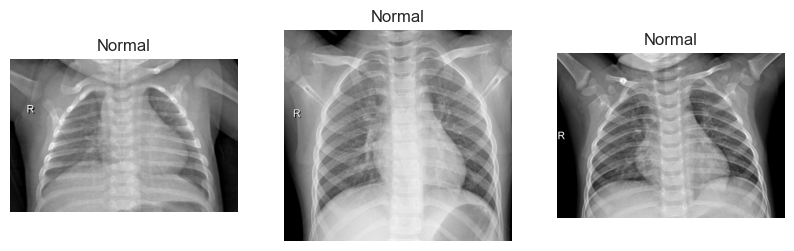

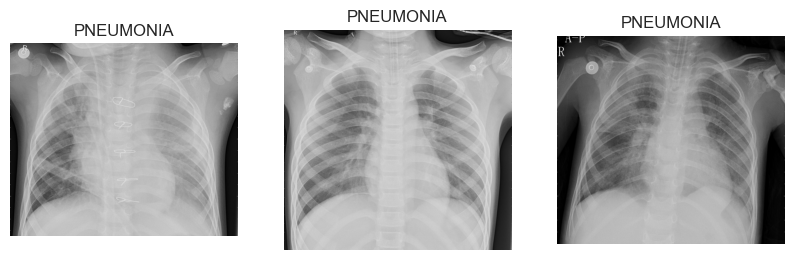

In [295]:
# Loading some images from the dataset to see how they look like
normal_chest_xray = ['IM-0164-0001.jpeg','IM-0176-0001.jpeg','IM-0145-0001.jpeg']
pneumonia_chest_xray = ['person3_bacteria_10.jpeg','person32_bacteria_165.jpeg','person348_virus_716.jpeg']

plt.figure(figsize=(10, 10))
for i, image in enumerate(normal_chest_xray):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(tf.keras.utils.load_img('chest_xray/train/NORMAL/{}'.format(image)))
    plt.title("Normal")
    plt.axis("off")

plt.show()

plt.figure(figsize=(10, 10))
for i, image in enumerate(pneumonia_chest_xray):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(tf.keras.utils.load_img('chest_xray/train/PNEUMONIA/{}'.format(image)))
    plt.title("PNEUMONIA")
    plt.axis("off")

**We observed that the size of the images for each category (Normal and Pneumonia) are different. Therefore, we will center crop the all the images in the dataset to 256x256 to :**

1. **Standardize all the images size to improve its accruacy**
2. **The model is able to focus on the important features of the image**

In [122]:
# Crop all the images to a certain size so that during training, the model will not be confused by the different sizes of the images and the object of interest will be in the center of the image.

crop_dir = './crop_images/'
sets = ["train", "val", "test"]
categories = ["NORMAL", "PNEUMONIA"]
crop_size = 256

# Create a new folder if it does not exist
if not os.path.exists(crop_dir):
    os.mkdir(crop_dir)

for set in sets:
    if not os.path.exists(crop_dir + "/" + set):
        os.mkdir(crop_dir + set)
    
    for category in categories:
        if not os.path.exists(crop_dir + "/" + set + "/" + category):
            os.mkdir(crop_dir + set + "/" + category)

        mass_crop_square("./chest_xray/" + set + "/" + category, crop_dir + set + "/" + category + "/", crop_size)    


# Create directory for model to save the model and weights
model_dir = './model'
models  = ["denseNet121"]

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

for name in models:
    if not os.path.exists(model_dir + "/" + name):
        os.mkdir(model_dir + "/" + name)
    

# Create directory for model to save the model and weights
model_dir = './augment_model'
models  = ["denseNet121"]

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

for name in models:
    if not os.path.exists(model_dir + "/" + name):
        os.mkdir(model_dir + "/" + name)


Destination path contains other files
Destination path contains other files
Destination path contains other files
Destination path contains other files
Destination path contains other files
Destination path contains other files


**We are creating new directory to store our saved model and weights. Addtionally, we are also center cropping all our images to a square to remove unnecessary information so that the model will be focusing on the relevant part which helps to improves its accuracy.**

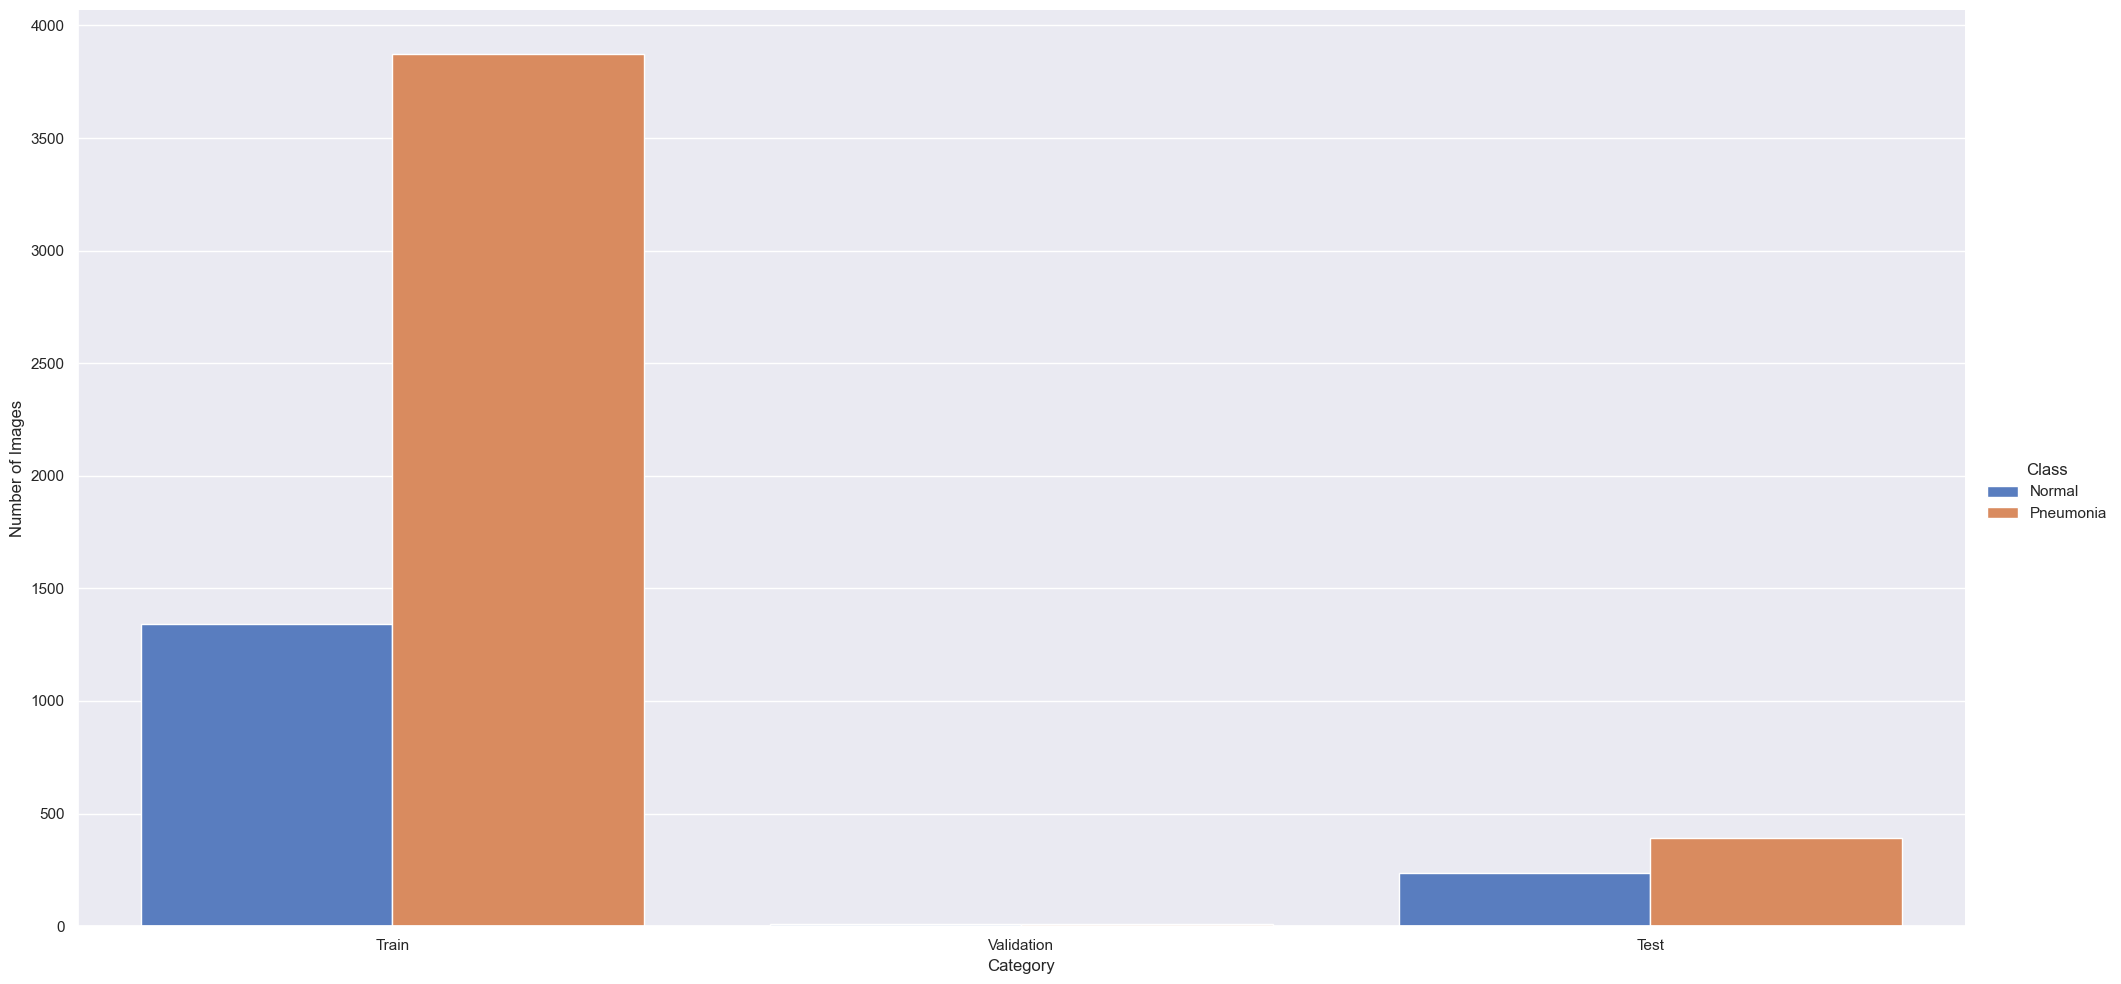

In [229]:
# Directories
train_dir = './crop_images/train'
val_dir = './crop_images/val'
test_dir = './crop_images/test'

# Check the number of images in each classes in the respecitve sets and plot them

train_normal = len(os.listdir(train_dir + "/NORMAL"))
train_pneumonia = len(os.listdir(train_dir + "/PNEUMONIA"))

val_normal = len(os.listdir(val_dir + "/NORMAL"))
val_pneumonia = len(os.listdir(val_dir + "/PNEUMONIA"))

test_normal = len(os.listdir(test_dir + "/NORMAL"))
test_pneumonia = len(os.listdir(test_dir + "/PNEUMONIA"))

num_images_df = pd.DataFrame({'Category': ['Train', 'Validation', 'Test'], 'Normal': [train_normal, val_normal, test_normal], 'Pneumonia': [train_pneumonia, val_pneumonia, test_pneumonia]})
num_images_df = pd.melt(num_images_df, id_vars="Category", var_name="Class", value_name="Number of Images")

sb.catplot(data = num_images_df, x="Category", y= "Number of Images", hue="Class", kind="bar", height= 10, aspect=2, palette="muted")




**Based on the graph, we can see that our dataset are highly unblanced and this will affect the performance of our model. Generally, we would like our train : validation : test  to follow a 60:20:20 split. A bad train test split will not allow the model to generalize well to new data which can lead to overfitting or underfittig of our model.**

**We can also observe that the number of images in each classes for the different sets are also unbalanced. This will also affect the performance of our model.**

**Hence, we will need to balance our dataset by generating more images from image augmentation or we simply combine all the sets as one then we split them up equally before we proceed with our model.**

Number of normal images:  1583 
Number of pneumonia images:  1583


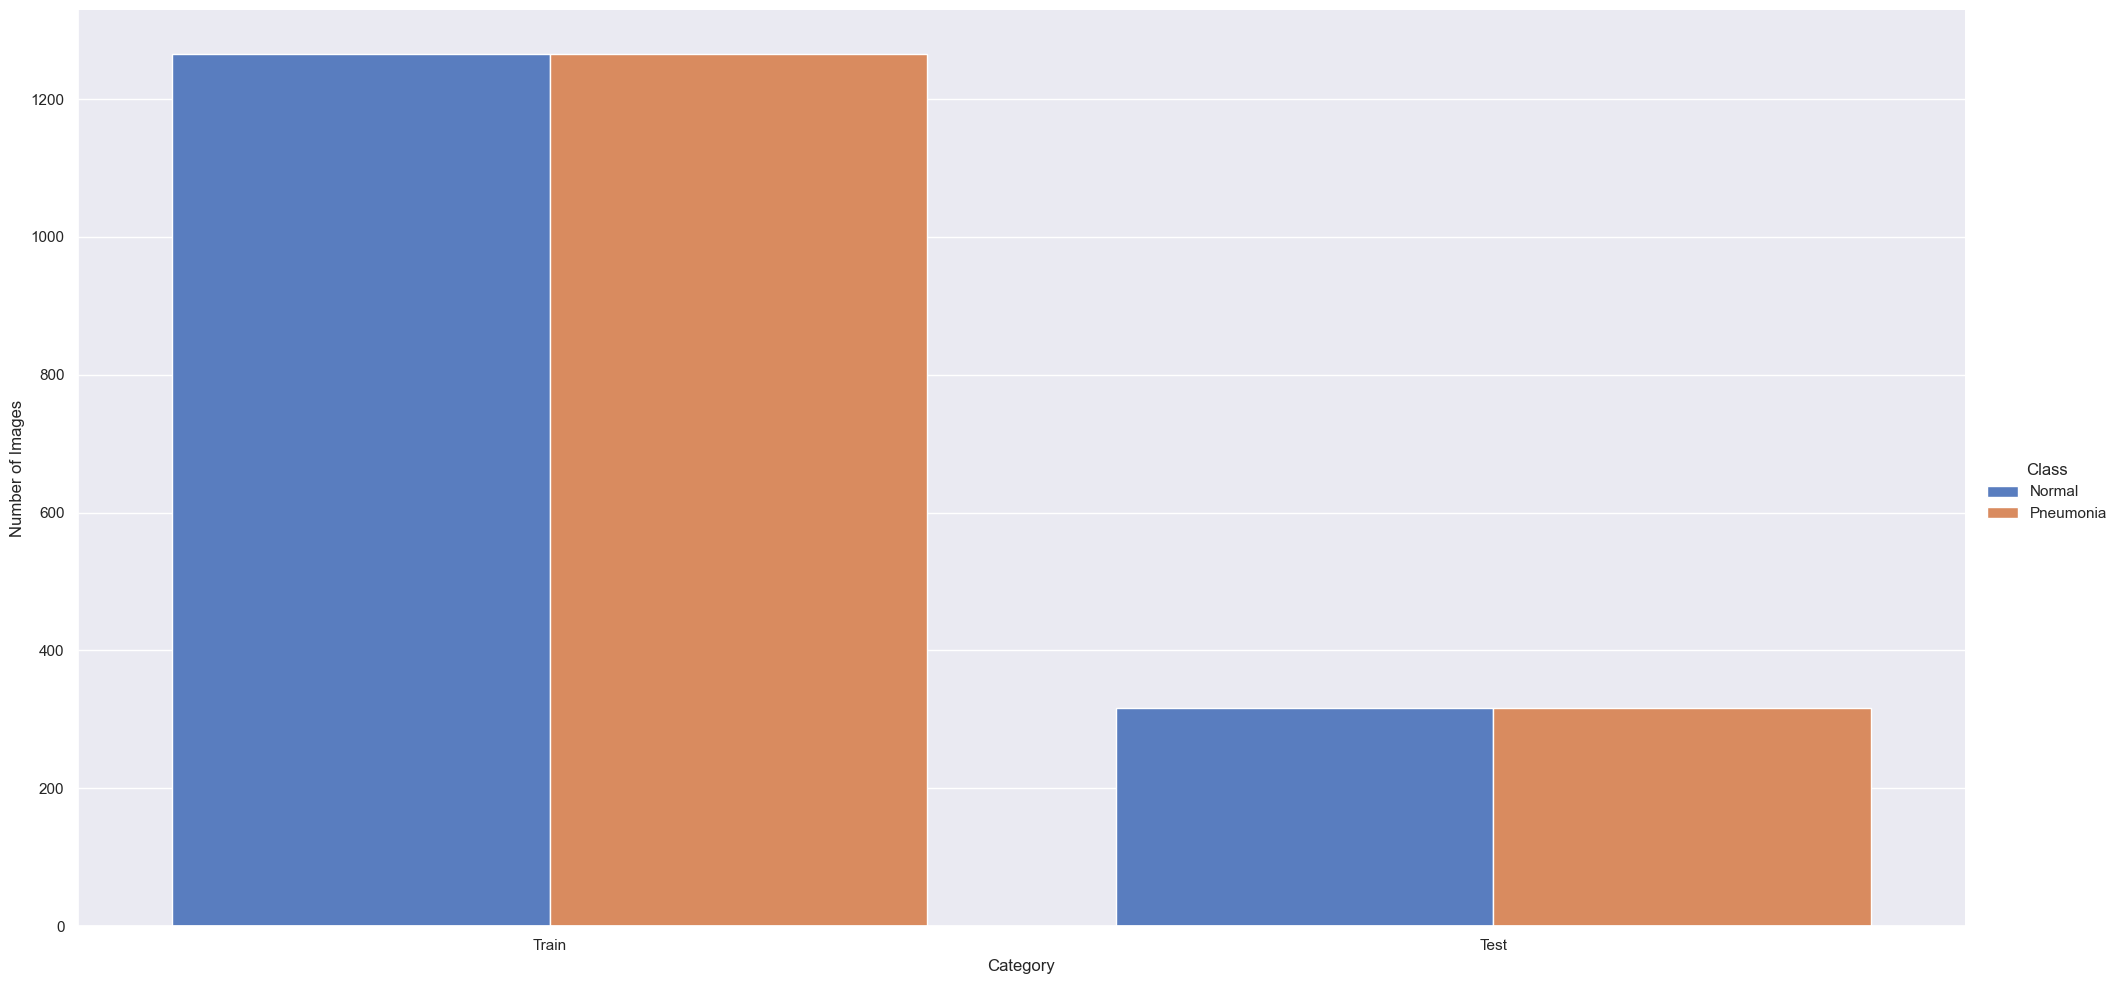

In [285]:
# We want to append all the path of the images into different lists

train_normal_images = [train_dir + "/NORMAL/" + f for f in os.listdir(train_dir + "/NORMAL")]
train_pneumonia_images = [train_dir + "/PNEUMONIA/" + f for f in os.listdir(train_dir + "/PNEUMONIA")]

val_normal_images = [val_dir + "/NORMAL/" + f for f in os.listdir(val_dir + "/NORMAL")]
val_pneumonia_images = [val_dir + "/PNEUMONIA/" + f for f in os.listdir(val_dir + "/PNEUMONIA")]

test_normal_images = [test_dir + "/NORMAL/" + f for f in os.listdir(test_dir + "/NORMAL")]
test_pneumonia_images = [test_dir + "/PNEUMONIA/" + f for f in os.listdir(test_dir + "/PNEUMONIA")]

# Create a dataframe with the path of the images and the labels
normal_images_list = train_normal_images + val_normal_images + test_normal_images
pneumonia_images_list = train_pneumonia_images + val_pneumonia_images + test_pneumonia_images

# Shuffle the images in the list to make sure that the model will not be biased
random.shuffle(normal_images_list)
random.shuffle(pneumonia_images_list)

# Balance the number of images in each class
pneumonia_images_list = pneumonia_images_list[:len(normal_images_list)]

print("Number of normal images: ", len(normal_images_list), "\nNumber of pneumonia images: ", len(pneumonia_images_list))


# Split each classes into 80% training,20% testing
train_normal_images, test_normal_images = train_test_split(normal_images_list, test_size=0.2, random_state=42)
train_pneumonia_images, test_pneumonia_images = train_test_split(pneumonia_images_list, test_size=0.2, random_state=42)


# Plot the number of image in each class with respect to its set

num_images_df = pd.DataFrame({'Category': ['Train', 'Test'], 'Normal': [len(train_normal_images), len(test_normal_images)], 'Pneumonia': [len(train_pneumonia_images), len(test_pneumonia_images)]})
num_images_df = pd.melt(num_images_df, id_vars="Category", var_name="Class", value_name="Number of Images")

sb.catplot(data = num_images_df, x="Category", y= "Number of Images", hue="Class", kind="bar", height= 10, aspect=2, palette="muted")



# Create seperate dataframe for train and test set with the label NORMAL and PNUEMONIA
train_df = pd.DataFrame({'path': train_normal_images + train_pneumonia_images, 'label': ['NORMAL'] * len(train_normal_images) + ['PNEUMONIA'] * len(train_pneumonia_images)})
test_df = pd.DataFrame({'path': test_normal_images + test_pneumonia_images, 'label': ['NORMAL'] * len(test_normal_images) + ['PNEUMONIA'] * len(test_pneumonia_images)})


**Now the dataset is balanced and we can proceed with our model.**

In [257]:
print("\033[92mTrain Dataframe \033[91mඞ")
display(train_df.head(5))
print("\033[92mTest Dataframe \033[91mඞ")
display(test_df.head(5))

Train Dataframe ඞ


,path,label
0,./crop_images/train/NORMAL/NORMAL2-IM-1181-000...,NORMAL
1,./crop_images/train/NORMAL/IM-0152-0001.jpeg.jpeg,NORMAL
2,./crop_images/train/NORMAL/NORMAL2-IM-0417-000...,NORMAL
3,./crop_images/test/NORMAL/NORMAL2-IM-0102-0001...,NORMAL
4,./crop_images/train/NORMAL/IM-0467-0001.jpeg.jpeg,NORMAL


Test Dataframe ඞ


,path,label
0,./crop_images/train/NORMAL/NORMAL2-IM-1347-000...,NORMAL
1,./crop_images/test/NORMAL/IM-0011-0001-0002.jp...,NORMAL
2,./crop_images/train/NORMAL/NORMAL2-IM-1316-000...,NORMAL
3,./crop_images/train/NORMAL/NORMAL2-IM-0392-000...,NORMAL
4,./crop_images/train/NORMAL/NORMAL2-IM-1004-000...,NORMAL


**Even though we have lesser number of pneumonia images, we will be able to train the model with the same number of images in each class. The model will be able to learn better with the same number of images in each class.**

In [259]:
# Loding the images from dataframe using keras ImageDataGenerator

train_datagen = ImageDataGenerator(validation_split=0.25).flow_from_dataframe(dataframe=train_df, directory=None, x_col="path", y_col="label", target_size=(256, 256), batch_size=32, seed=42, class_mode="categorical", subset="training")
val_datagen = ImageDataGenerator(validation_split=0.25).flow_from_dataframe(dataframe=train_df, directory=None, x_col="path", y_col="label", target_size=(256, 256), batch_size=32,seed=42,  class_mode="categorical", subset="validation")

test_datagen = ImageDataGenerator().flow_from_dataframe(dataframe=test_df, directory=None, x_col="path", y_col="label", target_size=(256, 256), batch_size=32, seed=42, class_mode="categorical")

Found 1899 validated image filenames belonging to 2 classes.
Found 633 validated image filenames belonging to 2 classes.
Found 634 validated image filenames belonging to 2 classes.


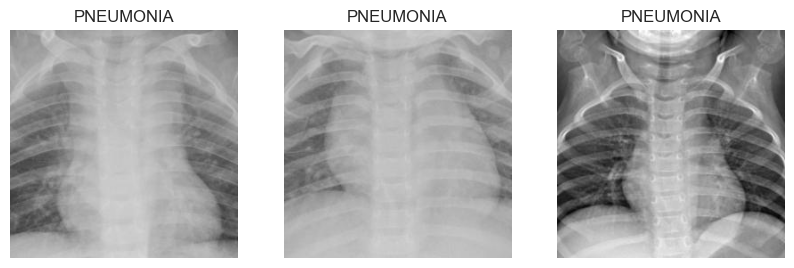

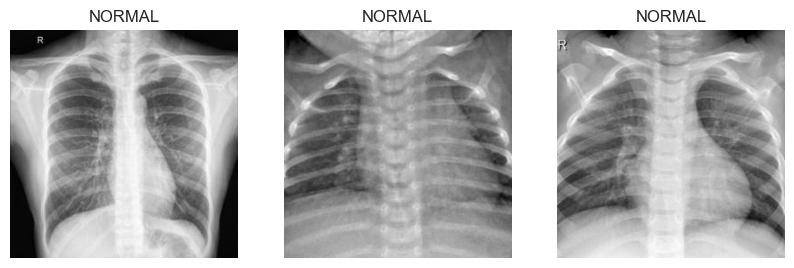

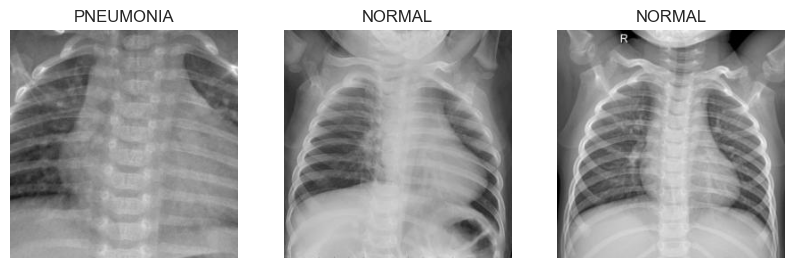

In [262]:
# Visualize the images from the generator
aug_printing_samples(train_datagen)
aug_printing_samples(val_datagen)
aug_printing_samples(test_datagen)


**Since the images labelled as pneumonia and normal looked similar to the human eye, I shall try to create a model with and without augmenting the images then comapre the performance of the two model**

**Generally, you will want to augement the images so that the model can learn more about the images as well as to prevent overfitting. However, since the images are already similar, I shall not augment them.**

# <span style="background-color: #25424C"> Deep Learning Model Building</span>

**To build my model, I am using transfer learning where my base model is DenseNet121 which has been trained on ImageNet dataset. Then I am freezing the layers to that they are not trained during the fie tuning process. Afterwards, I am adding my own classification layers on top of the pre-trained model and train these new layers with our dataset.**

**Reason why our team uses densetNet121 as our basemodel as it has a relatively small number of parameters compared to other depe learning models, thus, increasesing the the efficiency of the model and reducing the possibility of the model to be overfitted.**

**We are using the Adam optimizer with a learning rate of 0.0001 because Adam is commonly use in deep learning. It is similar to gradient descent that we have learn during class. It uses a moving average of the gradient and adjust the learning rate of each weight parameter.**

**ReduceLROnPlateau is a call back function that reduces the learning rate when a metric has stopped improving. This is useful when we are training a model with a large learning rate. But since we are using a small learning rate, the callback function is not gonna be of much use.**

In [272]:
optimizer = Adam(learning_rate=1e-4)
lrs = tf.keras.callbacks.ReduceLROnPlateau()
loss = tf.keras.losses.CategoricalCrossentropy()
int_lr = 0.0001
epoch = 30
batch_size = 32

# Early Stopping helps to stop the training process when the model stops improving. This is to reduce the amount of time needed to train over nuance changes in the model. 
early_stoppage = EarlyStopping(monitor='val_loss', patience=10)

# DenseNet Model
densed_Model = DenseNet121(include_top=False,input_tensor= tf.keras.Input(shape=(256,256,3)), weights='imagenet')


# Freeze the layers
for layer in densed_Model.layers[:101]:    
    layer.trainable = False

for layer in densed_Model.layers[101:]:  
    layer.trainable = True

# model = tf.keras.Sequential()
# model.add(densed_Model)
# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dense(256, activation='relu'))
# # Drop out is used to prevent overfitting. It randomly drops out a percentage of the nodes in the layer. This helps to prevent the model from learning the noise in the data.
# model.add(Dropout(0.7))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(2, activation='softmax'))

model = tf.keras.Sequential()
model.add(densed_Model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
model.fit(train_datagen, epochs=epoch, validation_data=val_datagen, callbacks=[early_stoppage,lrs])

model.summary()

model.save('./model/denseNet121/denseNetModel.h5')
model.save_weights('./model/denseNet121/denseNetWeights.h5')


Epoch 1/30


2023-03-24 02:06:09.348178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.7320

2023-03-24 02:08:19.461116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 172s 2s/step - loss: 0.5623 - accuracy: 0.7320 - val_loss: 0.0652 - val_accuracy: 0.9984 - lr: 1.0000e-04
Epoch 2/30
60/60 [==============================] - 46s 761ms/step - loss: 0.3346 - accuracy: 0.8747 - val_loss: 0.0577 - val_accuracy: 0.9779 - lr: 1.0000e-04
Epoch 3/30
60/60 [==============================] - 40s 668ms/step - loss: 0.2418 - accuracy: 0.9226 - val_loss: 0.0695 - val_accuracy: 0.9652 - lr: 1.0000e-04
Epoch 4/30
60/60 [==============================] - 41s 672ms/step - loss: 0.1788 - accuracy: 0.9510 - val_loss: 0.0634 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 5/30
60/60 [==============================] - 44s 739ms/step - loss: 0.1344 - accuracy: 0.9652 - val_loss: 0.1245 - val_accuracy: 0.9289 - lr: 1.0000e-04
Epoch 6/30
60/60 [==============================] - 45s 741ms/step - loss: 0.1246 - accuracy: 0.9658 - val_loss: 0.0918 - val_accuracy: 0.9510 - lr: 1.0000e-04
Epoch 7/30
60/60 [==============================] - 4

In [273]:
model.history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

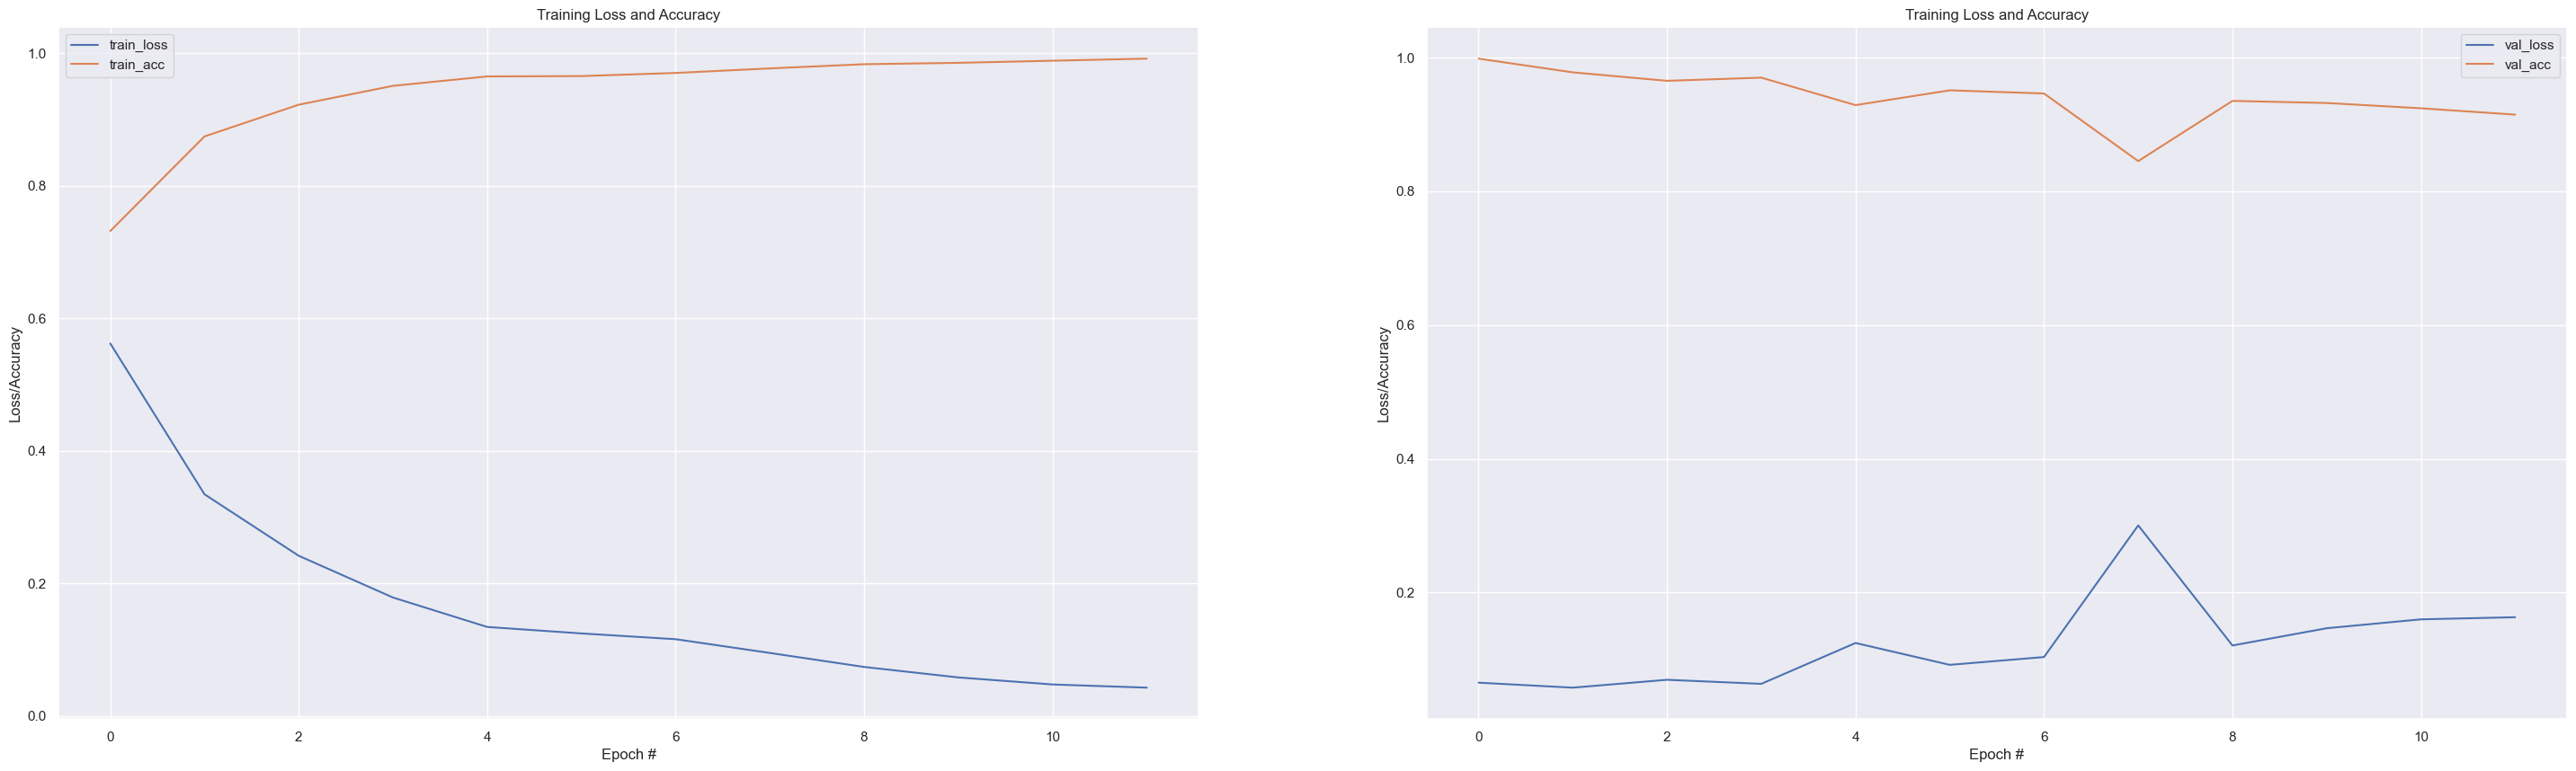

In [275]:
# Plotting the loss and accuracy
iteration = np.arange(0, 12)

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, model.history.history["loss"], label="train_loss")
plt.plot(iteration, model.history.history["accuracy"], label="train_acc")
plt.legend()


ax = plt.subplot(1, 2, 2)
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, model.history.history["val_loss"], label="val_loss")
plt.plot(iteration, model.history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [277]:
# load the model
model_load = tf.keras.models.load_model('./model/denseNet121/denseNetModel.h5')
model_load.load_weights('./model/denseNet121/denseNetWeights.h5')

# Evaluate the model
loss , accuracy = model_load.evaluate(test_datagen)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

2023-03-24 02:18:39.523623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 28s 1s/step - loss: 0.1472 - accuracy: 0.9543
Loss: 0.1472
Accuracy: 0.9543


In [282]:
print(_augment_confusion_matrix(model_load, test_datagen)[1])

              precision    recall  f1-score   support

      NORMAL       0.50      0.47      0.48       317
   PNEUMONIA       0.50      0.53      0.52       317

    accuracy                           0.50       634
   macro avg       0.50      0.50      0.50       634
weighted avg       0.50      0.50      0.50       634



**Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.**
**Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes.**

**Even though our accuracy is high, our precision and recall are low. This means that our model is not able to predict the positive class well.**
**Let's try to improve our model by augmenting the images.**

(0.0, 2.0, 2.0, 0.0)

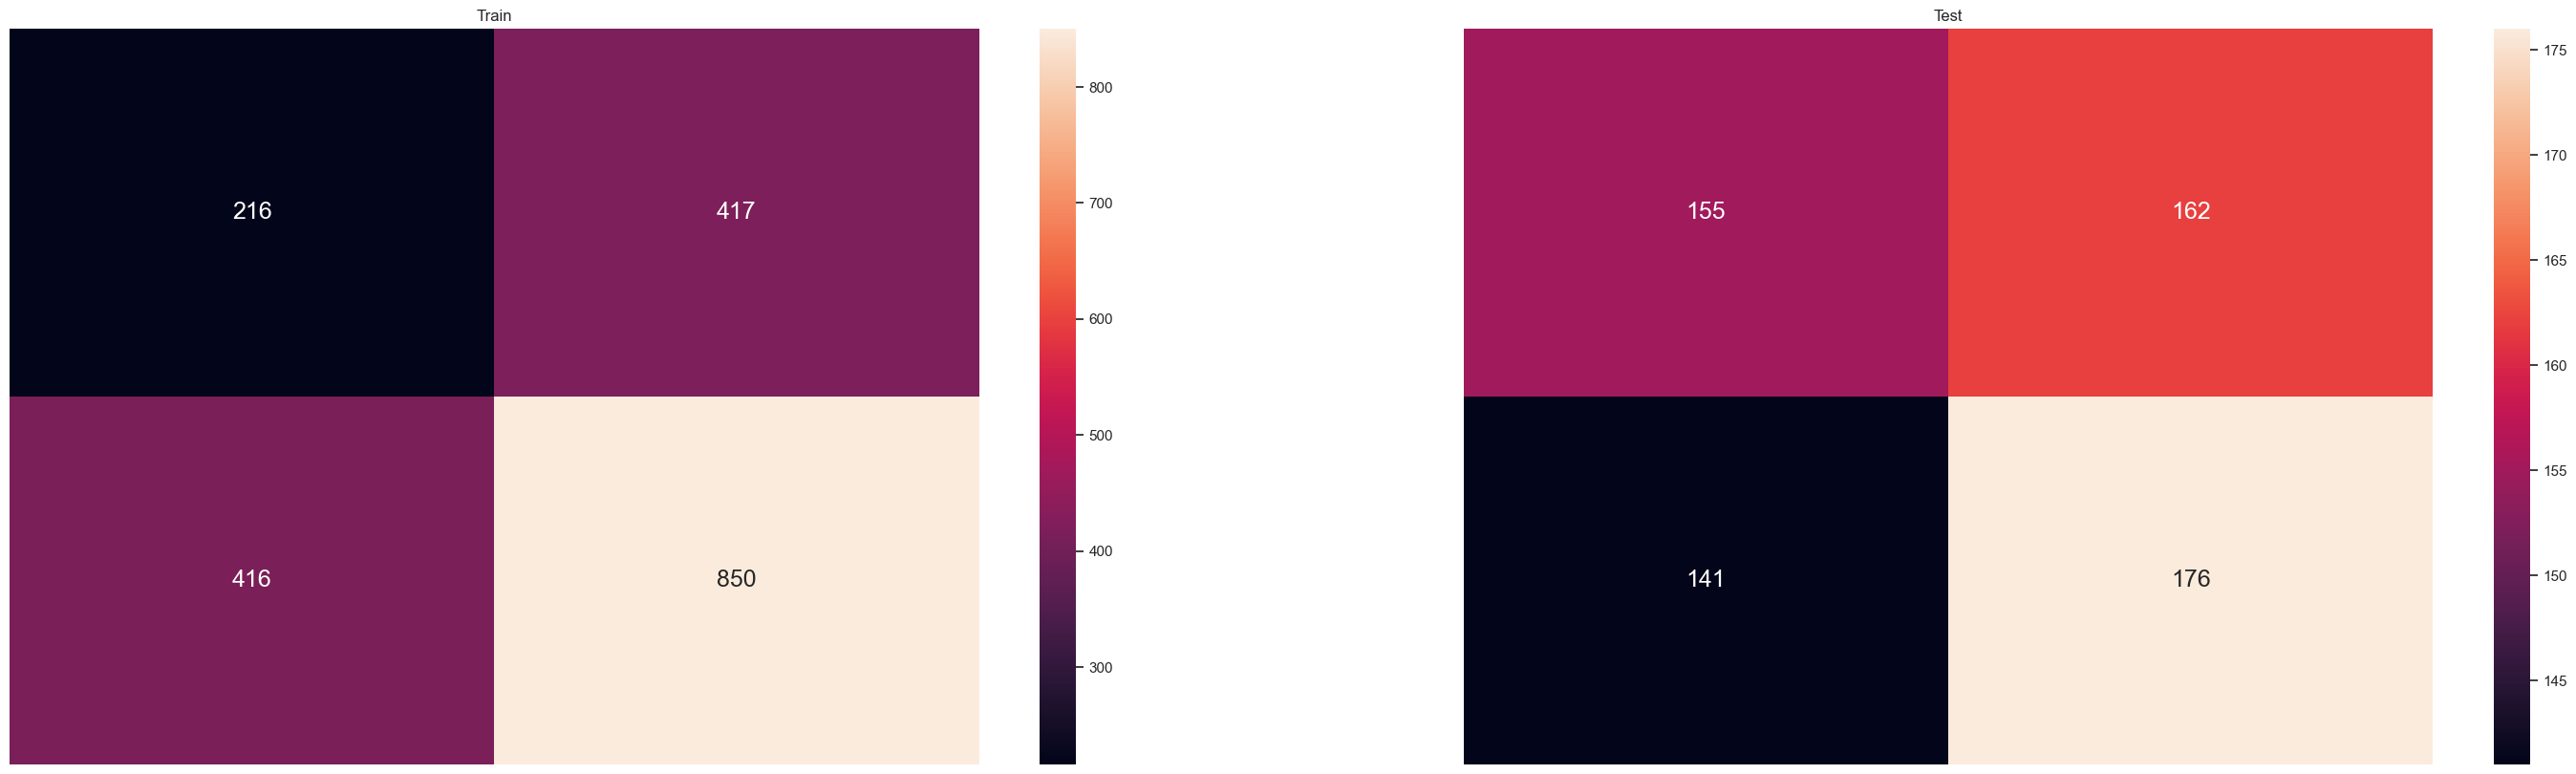

In [281]:
# Confusion matrix

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)
plt.title("Train")
sb.heatmap(_augment_confusion_matrix(model_load, train_datagen)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

ax = plt.subplot(1, 2, 2)
plt.title("Test")
sb.heatmap(_augment_confusion_matrix(model_load, test_datagen)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

# <span style="background-color: #FFA45B"> Augmented Image Version</span>


In [304]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False,
        validation_split=0.25
)

aug_train_datagen = datagen.flow_from_dataframe(dataframe=train_df, directory=None, x_col="path", y_col="label", target_size=(256, 256), batch_size=32, seed=42, class_mode="categorical", subset="training")
aug_val_datagen = datagen.flow_from_dataframe(dataframe=train_df, directory=None, x_col="path", y_col="label", target_size=(256, 256), batch_size=32,seed=42,  class_mode="categorical", subset="validation")

Found 1899 validated image filenames belonging to 2 classes.
Found 633 validated image filenames belonging to 2 classes.


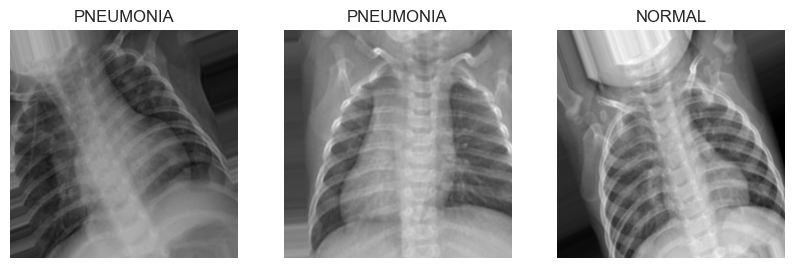

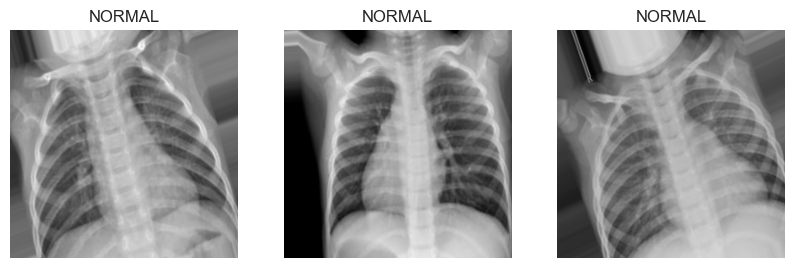

In [303]:
# Visualize the images from the generator
aug_printing_samples(aug_train_datagen)
aug_printing_samples(aug_val_datagen)


In [299]:
optimizer = Adam(learning_rate=1e-4)
lrs = tf.keras.callbacks.ReduceLROnPlateau()
loss = tf.keras.losses.CategoricalCrossentropy()
int_lr = 0.0001
epoch = 30
batch_size = 32

# Early Stopping helps to stop the training process when the model stops improving. This is to reduce the amount of time needed to train over nuance changes in the model. 
early_stoppage = EarlyStopping(monitor='val_loss', patience=10)

# DenseNet Model
densed_Model = DenseNet121(include_top=False,input_tensor= tf.keras.Input(shape=(256,256,3)), weights='imagenet')


# Freeze the layers
for layer in densed_Model.layers[:101]:    
    layer.trainable = False

for layer in densed_Model.layers[101:]:  
    layer.trainable = True

# model = tf.keras.Sequential()
# model.add(densed_Model)
# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dense(256, activation='relu'))
# # Drop out is used to prevent overfitting. It randomly drops out a percentage of the nodes in the layer. This helps to prevent the model from learning the noise in the data.
# model.add(Dropout(0.7))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(2, activation='softmax'))

model = tf.keras.Sequential()
model.add(densed_Model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
model.fit(train_datagen, epochs=epoch, validation_data=val_datagen, callbacks=[early_stoppage,lrs])

model.summary()

model.save('./augment_model/denseNet121/denseNetModel.h5')
model.save_weights('./augment_model/denseNet121/denseNetWeights.h5')


Epoch 1/30


2023-03-24 12:31:14.310858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - ETA: 0s - loss: 0.4898 - accuracy: 0.7599

2023-03-24 12:33:45.101619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 188s 2s/step - loss: 0.4898 - accuracy: 0.7599 - val_loss: 0.8813 - val_accuracy: 0.5845 - lr: 1.0000e-04
Epoch 2/30
60/60 [==============================] - 50s 819ms/step - loss: 0.2916 - accuracy: 0.8757 - val_loss: 0.3302 - val_accuracy: 0.9589 - lr: 1.0000e-04
Epoch 3/30
60/60 [==============================] - 50s 820ms/step - loss: 0.2251 - accuracy: 0.9200 - val_loss: 0.2718 - val_accuracy: 0.9431 - lr: 1.0000e-04
Epoch 4/30
60/60 [==============================] - 48s 786ms/step - loss: 0.1663 - accuracy: 0.9516 - val_loss: 0.1855 - val_accuracy: 0.9621 - lr: 1.0000e-04
Epoch 5/30
60/60 [==============================] - 44s 722ms/step - loss: 0.1363 - accuracy: 0.9679 - val_loss: 0.1766 - val_accuracy: 0.9510 - lr: 1.0000e-04
Epoch 6/30
60/60 [==============================] - 46s 760ms/step - loss: 0.1014 - accuracy: 0.9768 - val_loss: 0.1336 - val_accuracy: 0.9668 - lr: 1.0000e-04
Epoch 7/30
60/60 [==============================] - 4

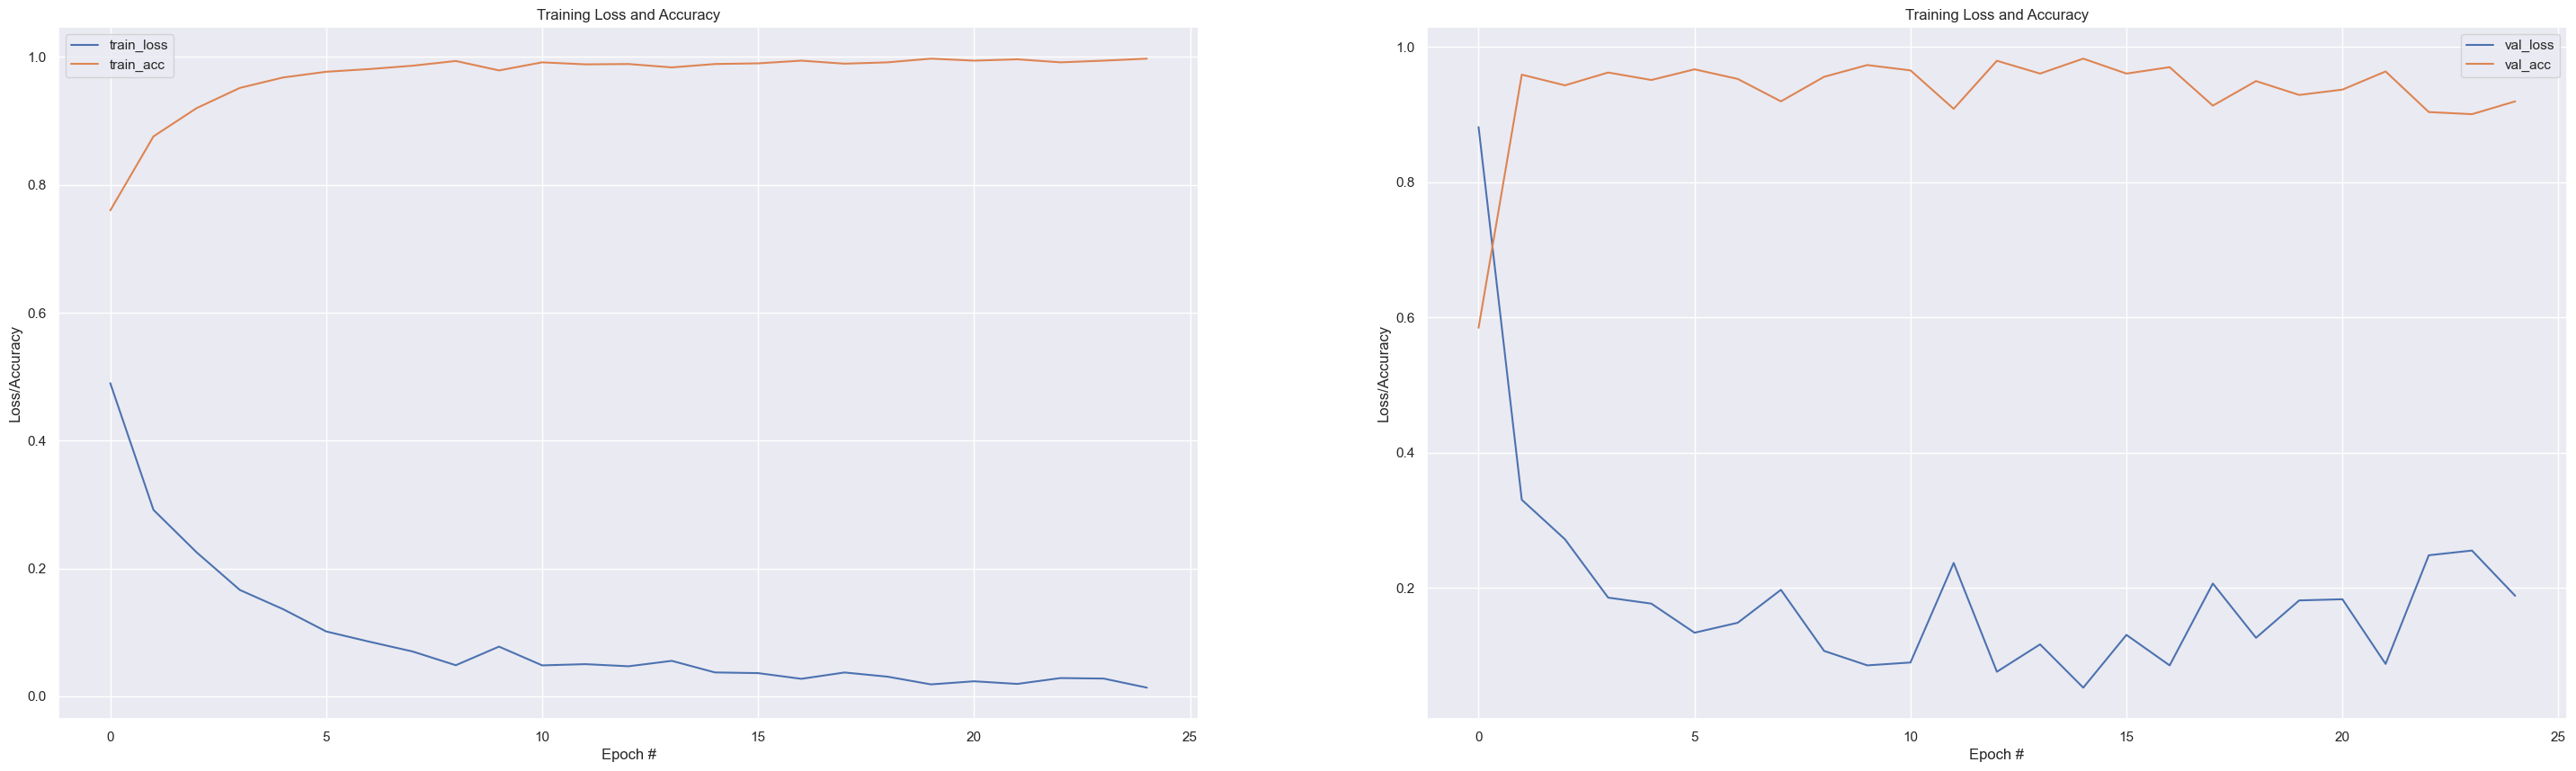

In [301]:
# Plotting the loss and accuracy
iteration = np.arange(0, 25)

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, model.history.history["loss"], label="train_loss")
plt.plot(iteration, model.history.history["accuracy"], label="train_acc")
plt.legend()


ax = plt.subplot(1, 2, 2)
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, model.history.history["val_loss"], label="val_loss")
plt.plot(iteration, model.history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [302]:
# load the model
model_load = tf.keras.models.load_model('./augment_model/denseNet121/denseNetModel.h5')
model_load.load_weights('./augment_model/denseNet121/denseNetWeights.h5')

# Evaluate the model
loss , accuracy = model_load.evaluate(test_datagen)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

2023-03-24 12:53:35.265095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 50s 2s/step - loss: 0.1348 - accuracy: 0.9606
Loss: 0.1348
Accuracy: 0.9606


In [305]:
print(_augment_confusion_matrix(model_load, test_datagen)[1])

2023-03-24 12:54:54.311200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      NORMAL       0.50      0.47      0.49       317
   PNEUMONIA       0.50      0.53      0.51       317

    accuracy                           0.50       634
   macro avg       0.50      0.50      0.50       634
weighted avg       0.50      0.50      0.50       634



(0.0, 2.0, 2.0, 0.0)

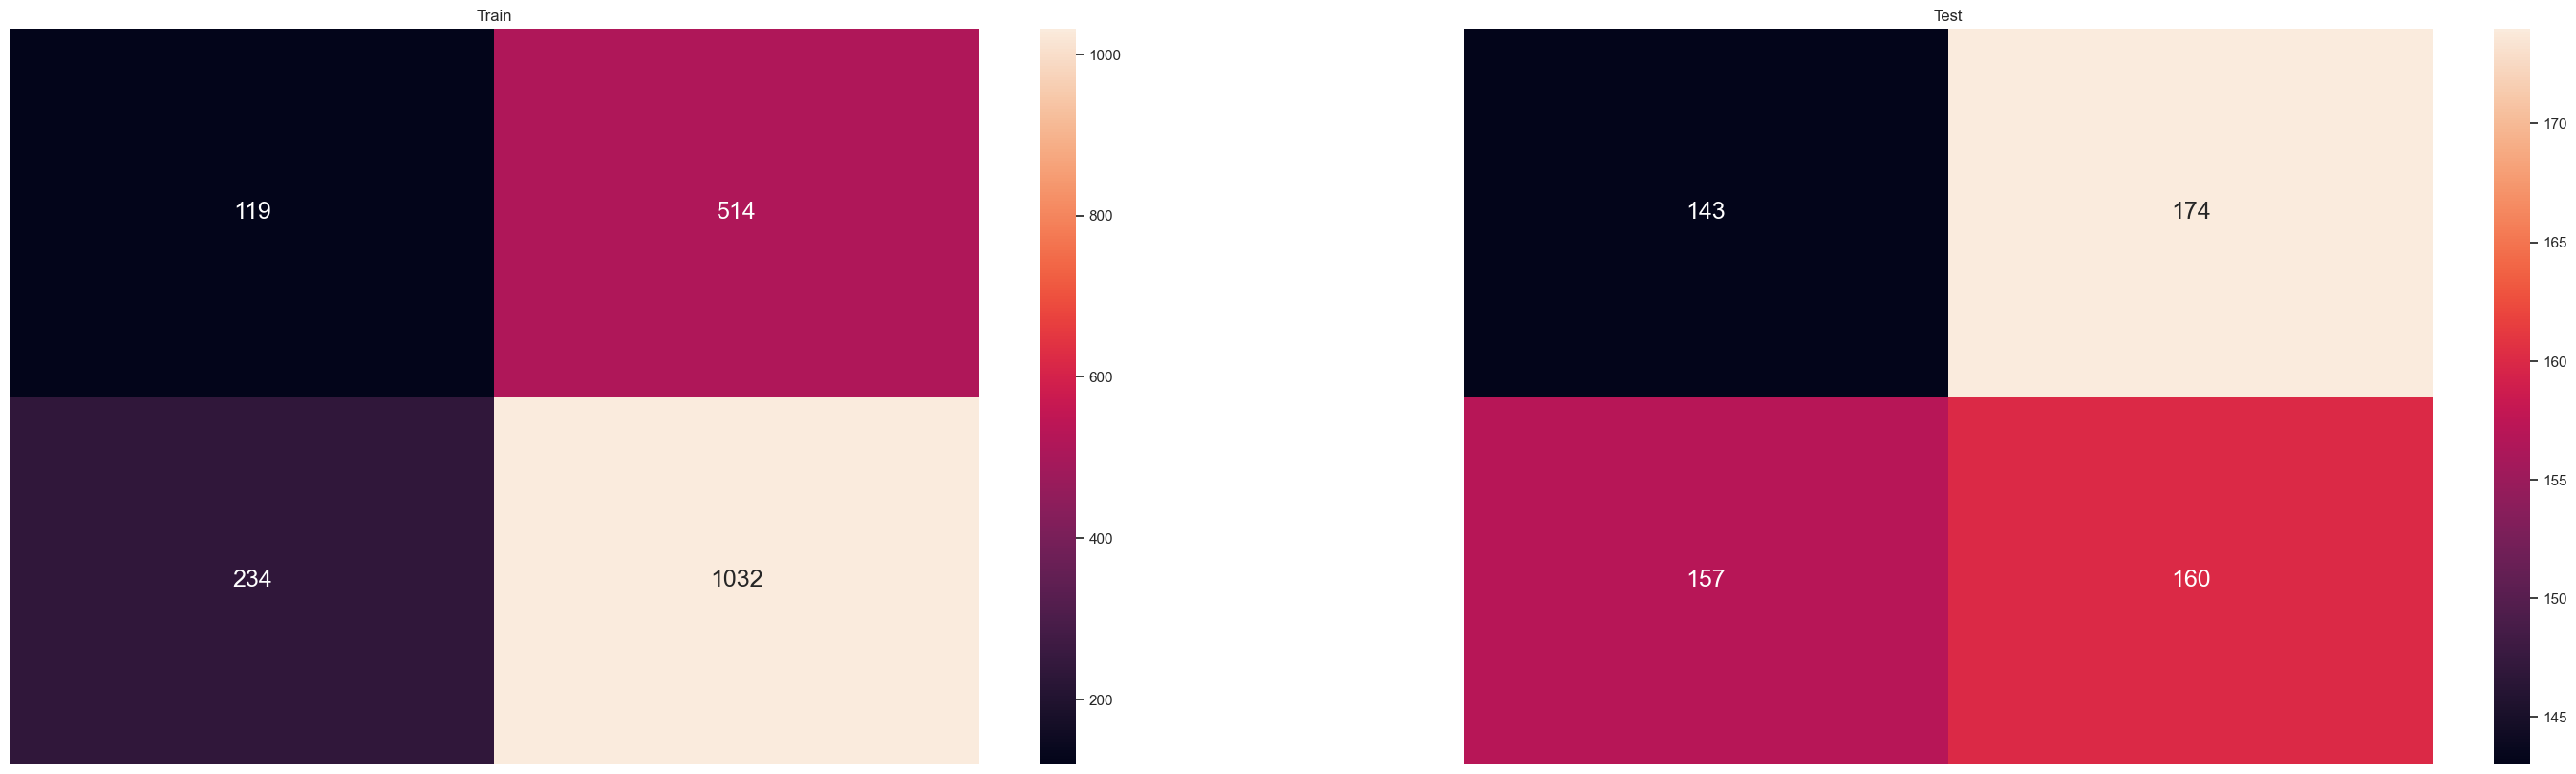

In [306]:
# Confusion matrix

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)
plt.title("Train")
sb.heatmap(_augment_confusion_matrix(model_load, aug_train_datagen)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

ax = plt.subplot(1, 2, 2)
plt.title("Test")
sb.heatmap(_augment_confusion_matrix(model_load, test_datagen)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

# <span style="background-color: #cc2f42"> Non Resampled Images ඞ </span>

**The code below is to train the model with the non resampled images meaning that the data is highly unbalanced**

In [123]:
# Loading of image data
training_set = tf.keras.utils.image_dataset_from_directory(crop_dir+'train/',
                                                            labels = "inferred",
                                                            label_mode = "categorical",
                                                            color_mode = "rgb",
                                                            batch_size = 32,
                                                            image_size = (256,256),
                                                            seed = 1234)

validation_set = tf.keras.utils.image_dataset_from_directory(crop_dir+'val/',
                                                            labels = "inferred",
                                                            label_mode = "categorical",
                                                            color_mode = "rgb",
                                                            batch_size = 32,
                                                            image_size = (256,256),
                                                            seed = 1234)
test_set = tf.keras.utils.image_dataset_from_directory(crop_dir+'test/',
                                                            labels = "inferred",
                                                            label_mode = "categorical",
                                                            color_mode = "rgb",
                                                            batch_size = 32,
                                                            image_size = (256,256),
                                                            seed = 1234)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


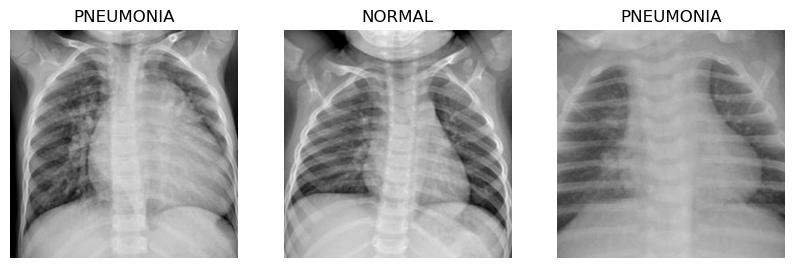

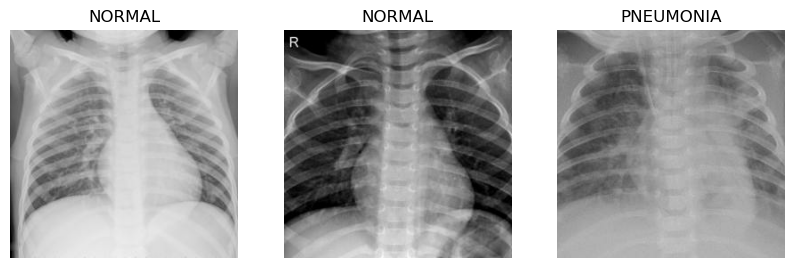

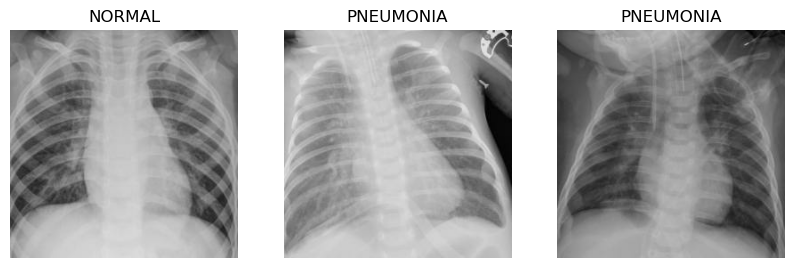

In [124]:
# Visualise the images
printing_samples(training_set)
printing_samples(validation_set)
printing_samples(test_set)


Since the images labelled as pneumonia and normal looked similar to the human eye, I shall try to create a model without augmenting them. 

Generally, you will want to augement the images so that the model can learn more about the images as well as to prevent overfitting. However, since the images are already similar, I shall not augment them.

In [125]:
# Check if GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# Check if MPS is available
# MPS is for pytorch to leverage on M1 GPU
torch.device("mps")
print(torch.backends.mps.is_built() and torch.backends.mps.is_available())



GPU is available
True


In [271]:
optimizer = Adam(learning_rate=1e-4)
lrs = tf.keras.callbacks.ReduceLROnPlateau()
loss = tf.keras.losses.CategoricalCrossentropy()
int_lr = 0.0001
epoch = 30
batch_size = 32

# Early Stopping helps to stop the training process when the model stops improving. This is to reduce the amount of time needed to train over nuance changes in the model. 
early_stoppage = EarlyStopping(monitor='val_loss', patience=10)

We are leveraging on transfer learning to create our model as we do not have enough data to train a model from scratch. Transfer learning helps us to use a pre-trained model and fine-tune it to our dataset. 

We will be taking layers from a denseNet121 model, freeze a portion of the layers to avoid destroying any information they contain and add our own layers to the model. By adding our own layers, we are able to fine-tune the model to our dataset.

In [127]:
# DenseNet Model

densed_Model = DenseNet121(include_top=False,input_tensor= tf.keras.Input(shape=(256,256,3)), weights='imagenet')


# Freeze the layers
for layer in densed_Model.layers[:101]:    
    layer.trainable = False

for layer in densed_Model.layers[101:]:  
    layer.trainable = True

# model = tf.keras.Sequential()
# model.add(densed_Model)
# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dense(256, activation='relu'))
# # Drop out is used to prevent overfitting. It randomly drops out a percentage of the nodes in the layer. This helps to prevent the model from learning the noise in the data.
# model.add(Dropout(0.7))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(2, activation='softmax'))

model = tf.keras.Sequential()
model.add(densed_Model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))




In [128]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
model.fit(training_set, epochs=epoch, validation_data=validation_set, callbacks=[early_stoppage,lrs])

model.summary()

model.save('./aug/denseNet121/denseNetModel.h5')
model.save_weights('./model/denseNet121/denseNetWeights.h5')


Epoch 1/30


2023-03-23 22:52:26.687970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - ETA: 0s - loss: 0.3366 - accuracy: 0.8706

2023-03-23 22:54:23.054932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 127s 632ms/step - loss: 0.3366 - accuracy: 0.8706 - val_loss: 0.3662 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/30
163/163 [==============================] - 81s 489ms/step - loss: 0.1365 - accuracy: 0.9636 - val_loss: 0.4783 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 3/30
163/163 [==============================] - 77s 471ms/step - loss: 0.0972 - accuracy: 0.9716 - val_loss: 0.4573 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 4/30
163/163 [==============================] - 77s 474ms/step - loss: 0.0694 - accuracy: 0.9827 - val_loss: 0.3385 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 5/30
163/163 [==============================] - 78s 477ms/step - loss: 0.0518 - accuracy: 0.9854 - val_loss: 0.2080 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 6/30
163/163 [==============================] - 77s 475ms/step - loss: 0.0381 - accuracy: 0.9906 - val_loss: 0.3820 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 7/30
163/163 [==================

In [132]:
model.history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


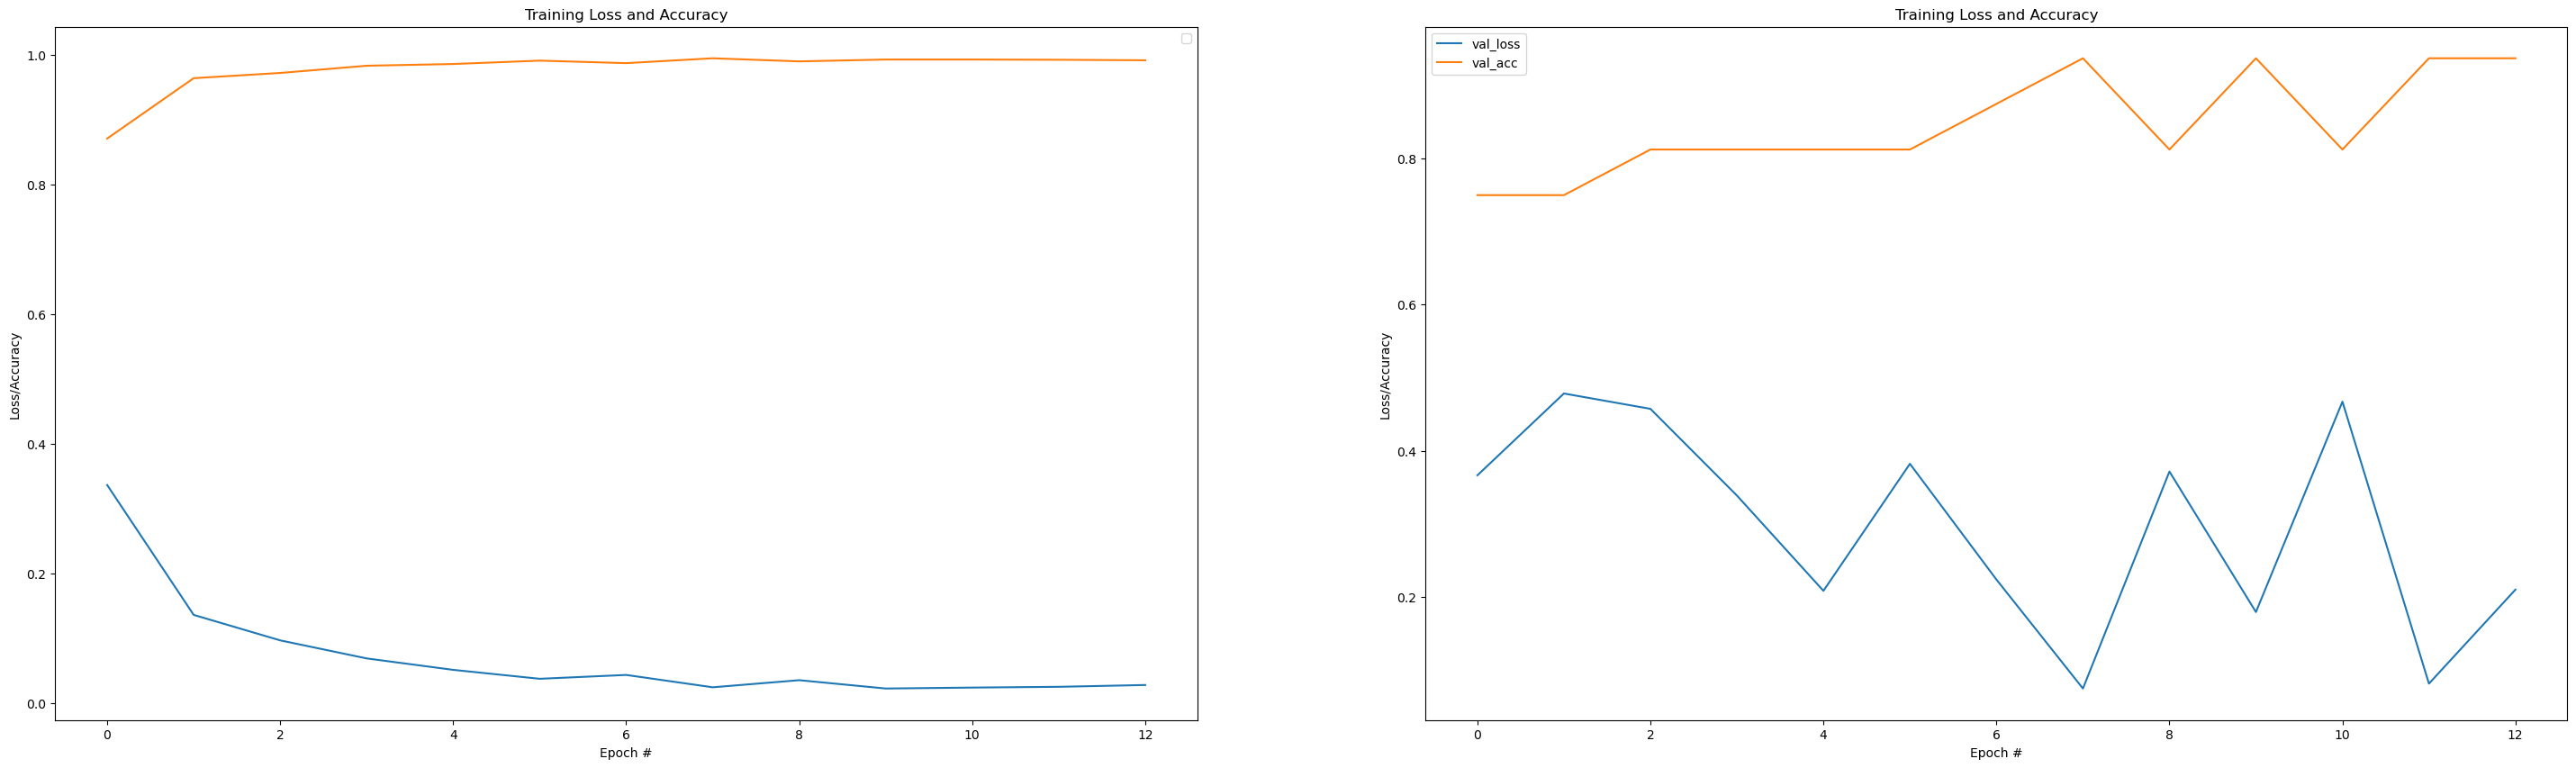

In [133]:
# Plotting the loss and accuracy
iteration = np.arange(0, 13)

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, model.history.history["loss"], label="train_loss")
plt.plot(iteration, model.history.history["accuracy"], label="train_acc")
plt.legend()


ax = plt.subplot(1, 2, 2)
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, model.history.history["val_loss"], label="val_loss")
plt.plot(iteration, model.history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [134]:
# load the model
model_load = tf.keras.models.load_model('./model/denseNet121/denseNetModel.h5')
model_load.load_weights('./model/denseNet121/denseNetWeights.h5')

# Evaluate the model
loss , accuracy = model_load.evaluate(test_set)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')


2023-03-23 23:32:19.224342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 19s 664ms/step - loss: 0.8933 - accuracy: 0.8061
Loss: 0.8933
Accuracy: 0.8061


In [135]:

print(_confusion_matrix(model_load, test_set)[1])

2023-03-23 23:32:41.531367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-23 23:32:52.654825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      NORMAL       1.00      0.48      0.65       234
   PNEUMONIA       0.76      1.00      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.74      0.76       624
weighted avg       0.85      0.81      0.79       624



(0.0, 2.0, 2.0, 0.0)

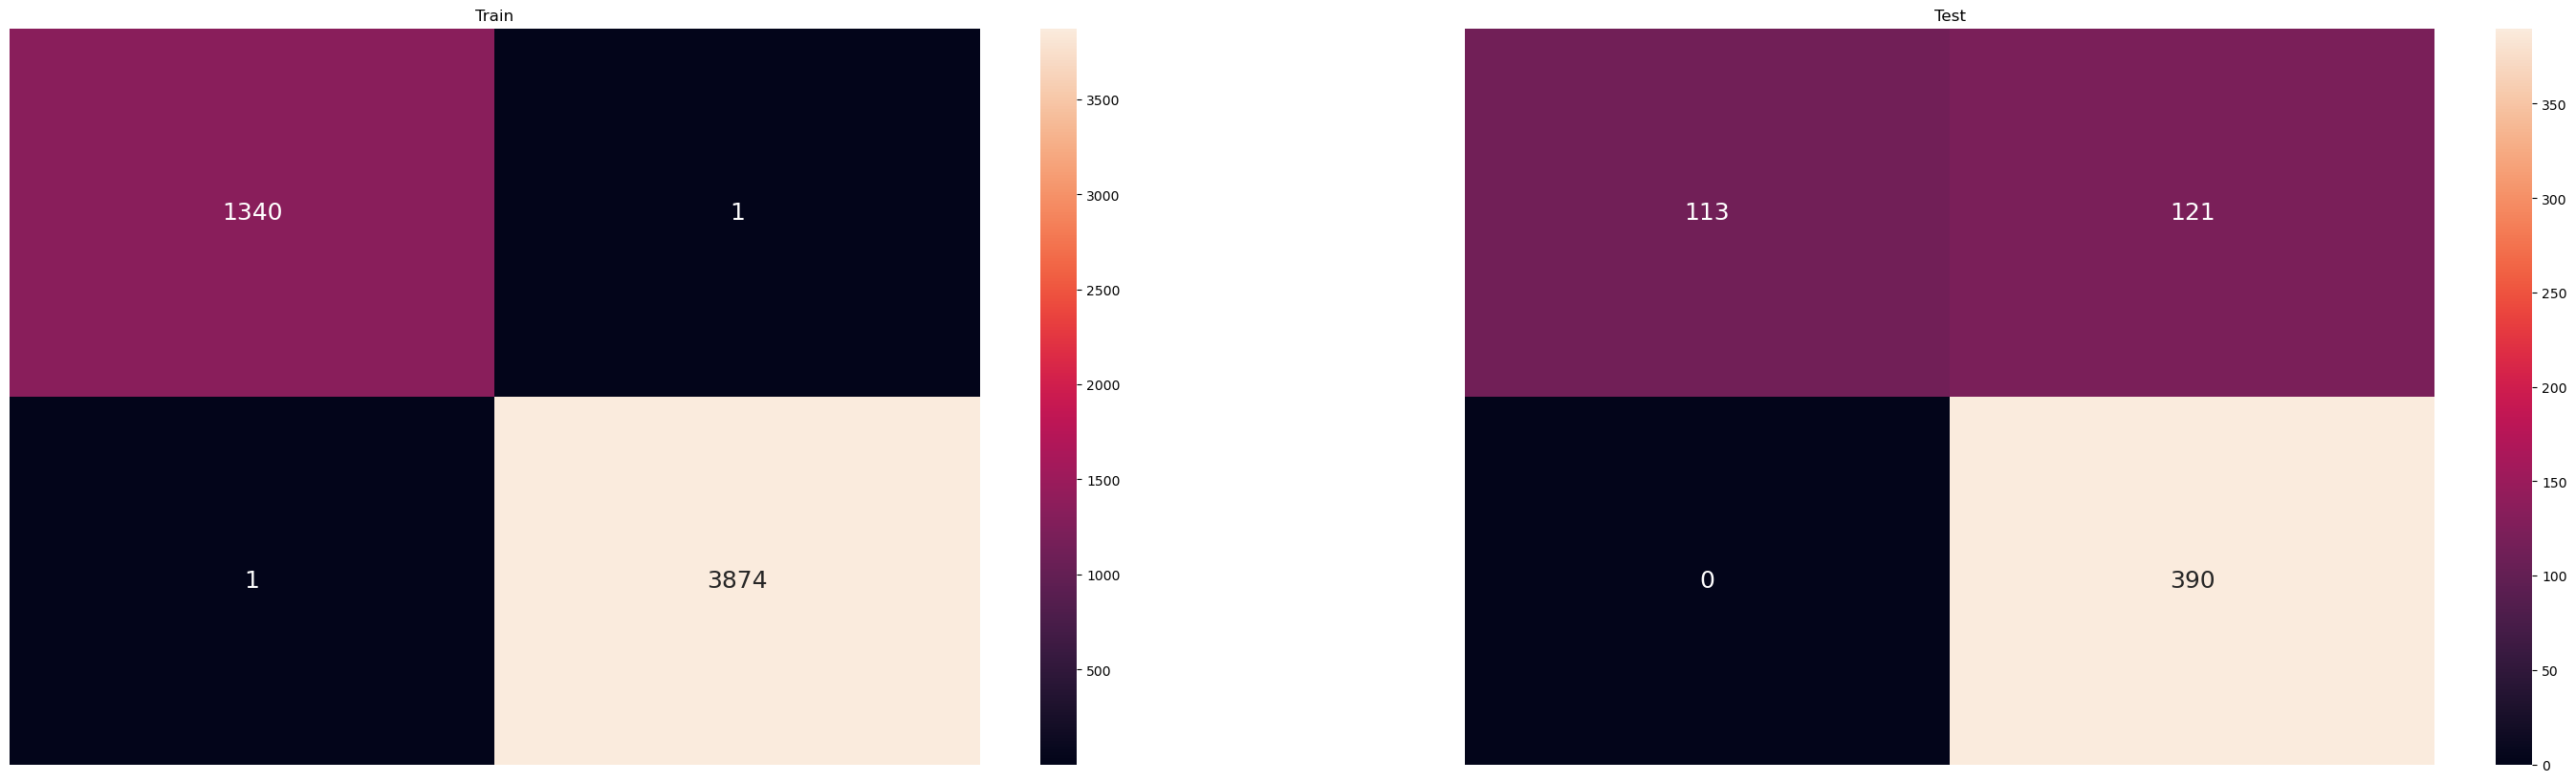

In [136]:
plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)
plt.title("Train")
sb.heatmap(_confusion_matrix(model_load, training_set)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

ax = plt.subplot(1, 2, 2)
plt.title("Test")
sb.heatmap(_confusion_matrix(model_load, test_set)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

2023-03-23 23:34:17.065925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


(-0.5, 255.5, 255.5, -0.5)

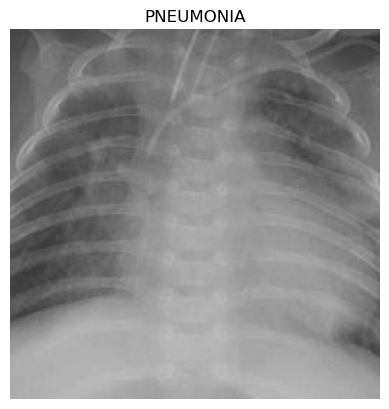

In [137]:
image = tf.keras.utils.load_img("./crop_images/test/PNEUMONIA/person1_virus_8.jpeg.jpeg", target_size=(256, 256))

# load the model
model_load = tf.keras.models.load_model('./model/denseNet121/denseNetModel.h5')
model_load.load_weights('./model/denseNet121/denseNetWeights.h5')

preds = model_load.predict(np.expand_dims(image, axis=0))

i = preds.argmax(axis=1)[0]


plt.imshow(image)
plt.title(training_set.class_names[i])
plt.axis("off")

# Augmented Image Version

We will be using the same model as above but with augmented images. This is to see if the model can learn more about the images and improve the accuracy.

In [138]:
# Augment Image with ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False
)

# Generate the augmented images
augmented_train_ds = datagen.flow_from_directory(crop_dir+"/train",
                                                target_size=(256, 256),
                                                batch_size=32,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                seed=1234)

augmented_val_ds = datagen.flow_from_directory(crop_dir+"/val",
                                                target_size=(256, 256),
                                                batch_size=32,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                seed=1234)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


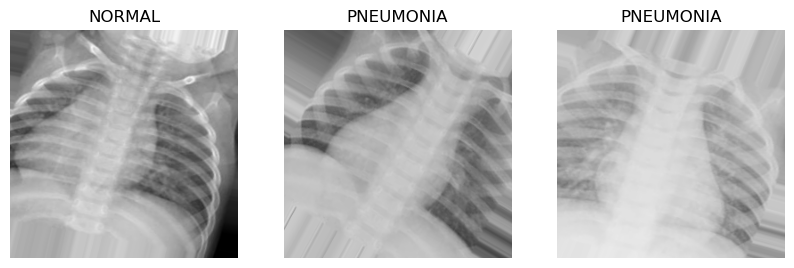

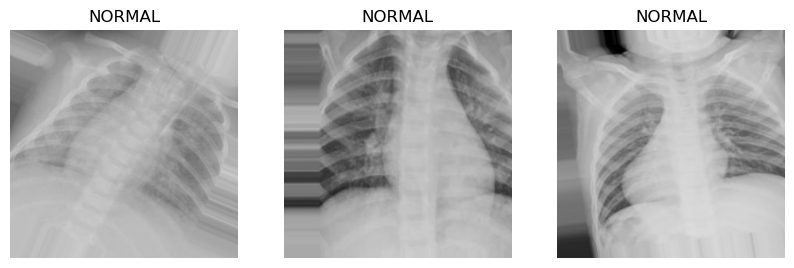

In [140]:
# Visualise the augmented images
aug_printing_samples(augmented_train_ds)
aug_printing_samples(augmented_val_ds)


In [141]:
optimizer = Adam(learning_rate=1e-4)
lrs = tf.keras.callbacks.ReduceLROnPlateau()
loss = tf.keras.losses.CategoricalCrossentropy()
int_lr = 0.0001
epoch = 30
batch_size = 32

# Early Stopping helps to stop the training process when the model stops improving. This is to reduce the amount of time needed to train over nuance changes in the model. 
early_stoppage = EarlyStopping(monitor='val_loss', patience=10)

# DenseNet Model

densed_Model = DenseNet121(include_top=False,input_tensor= tf.keras.Input(shape=(256,256,3)), weights='imagenet')


# Freeze the layers
for layer in densed_Model.layers[:149]:    
    layer.trainable = False

for layer in densed_Model.layers[149:]:  
    layer.trainable = True

# model = tf.keras.Sequential()
# model.add(densed_Model)
# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dense(256, activation='relu'))
# # Drop out is used to prevent overfitting. It randomly drops out a percentage of the nodes in the layer. This helps to prevent the model from learning the noise in the data.
# model.add(Dropout(0.7))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(2, activation='softmax'))

model = tf.keras.Sequential()
model.add(densed_Model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
model.fit(augmented_train_ds, epochs=epoch, validation_data=augmented_val_ds, callbacks=[lrs])

model.summary()

model.save('./augment_model/denseNet121/denseNetModel.h5')
model.save_weights('./augment_model/denseNet121/denseNetWeights.h5')


Epoch 1/30


2023-03-23 23:35:07.533864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - ETA: 0s - loss: 0.5864 - accuracy: 0.7107

2023-03-23 23:36:53.215198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 122s 571ms/step - loss: 0.5864 - accuracy: 0.7107 - val_loss: 0.5644 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/30
163/163 [==============================] - 75s 450ms/step - loss: 0.3121 - accuracy: 0.8708 - val_loss: 0.6497 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/30
163/163 [==============================] - 72s 437ms/step - loss: 0.2177 - accuracy: 0.9233 - val_loss: 0.6506 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 4/30
163/163 [==============================] - 66s 402ms/step - loss: 0.1720 - accuracy: 0.9452 - val_loss: 0.7924 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 5/30
163/163 [==============================] - 67s 409ms/step - loss: 0.1490 - accuracy: 0.9505 - val_loss: 0.9312 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 6/30
163/163 [==============================] - 62s 382ms/step - loss: 0.1419 - accuracy: 0.9526 - val_loss: 1.1665 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/30
163/163 [==================

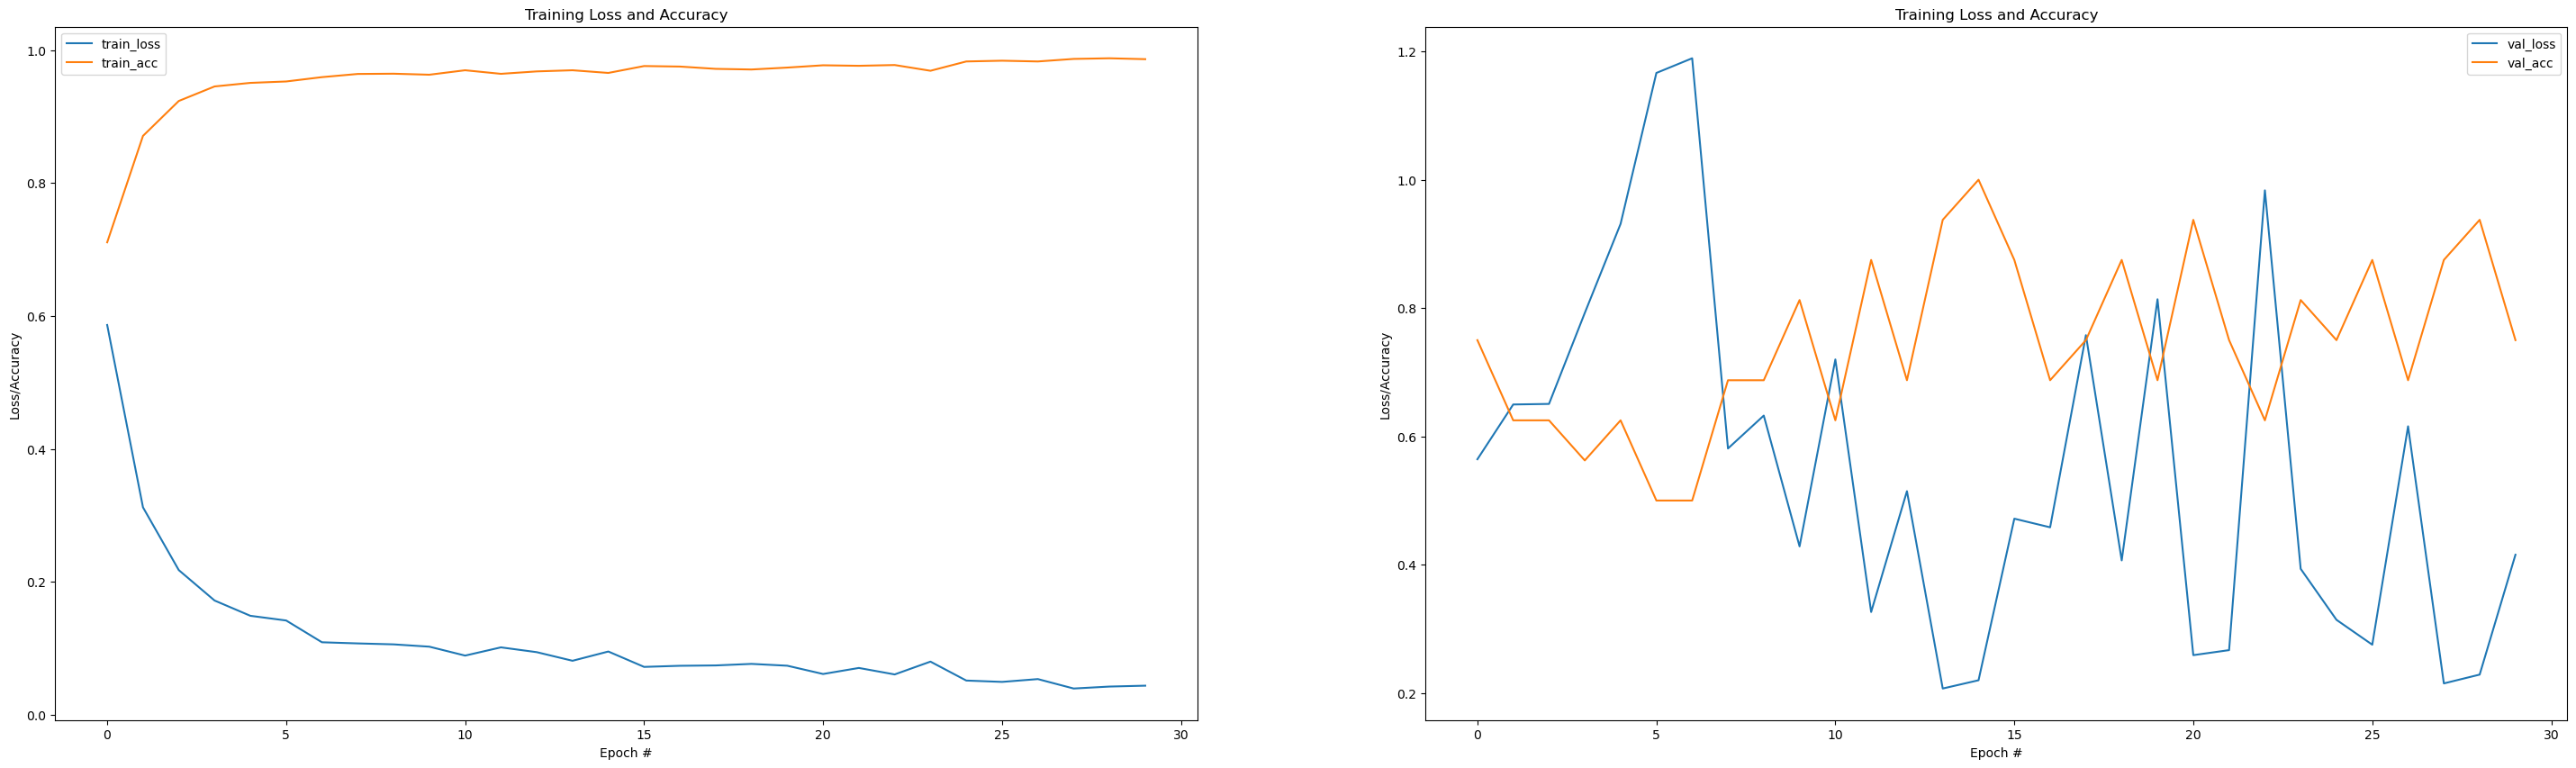

In [142]:
# Plotting the loss and accuracy
iteration = np.arange(0, 30)

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, model.history.history["loss"], label="train_loss")
plt.plot(iteration, model.history.history["accuracy"], label="train_acc")
plt.legend()


ax = plt.subplot(1, 2, 2)
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, model.history.history["val_loss"], label="val_loss")
plt.plot(iteration, model.history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [143]:
# load the model
model_load = tf.keras.models.load_model('./augment_model/denseNet121/denseNetModel.h5')
model_load.load_weights('./augment_model/denseNet121/denseNetWeights.h5')

# Evaluate the model
loss , accuracy = model_load.evaluate(test_set)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')


print(_confusion_matrix(model_load, test_set)[1])


2023-03-24 00:08:41.766062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 19s 720ms/step - loss: 0.4658 - accuracy: 0.8494
Loss: 0.4658
Accuracy: 0.8494


2023-03-24 00:09:02.682607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-24 00:09:14.756857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      NORMAL       0.99      0.60      0.75       234
   PNEUMONIA       0.81      1.00      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.80      0.82       624
weighted avg       0.88      0.85      0.84       624



2023-03-24 00:09:23.674955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(0.0, 2.0, 2.0, 0.0)

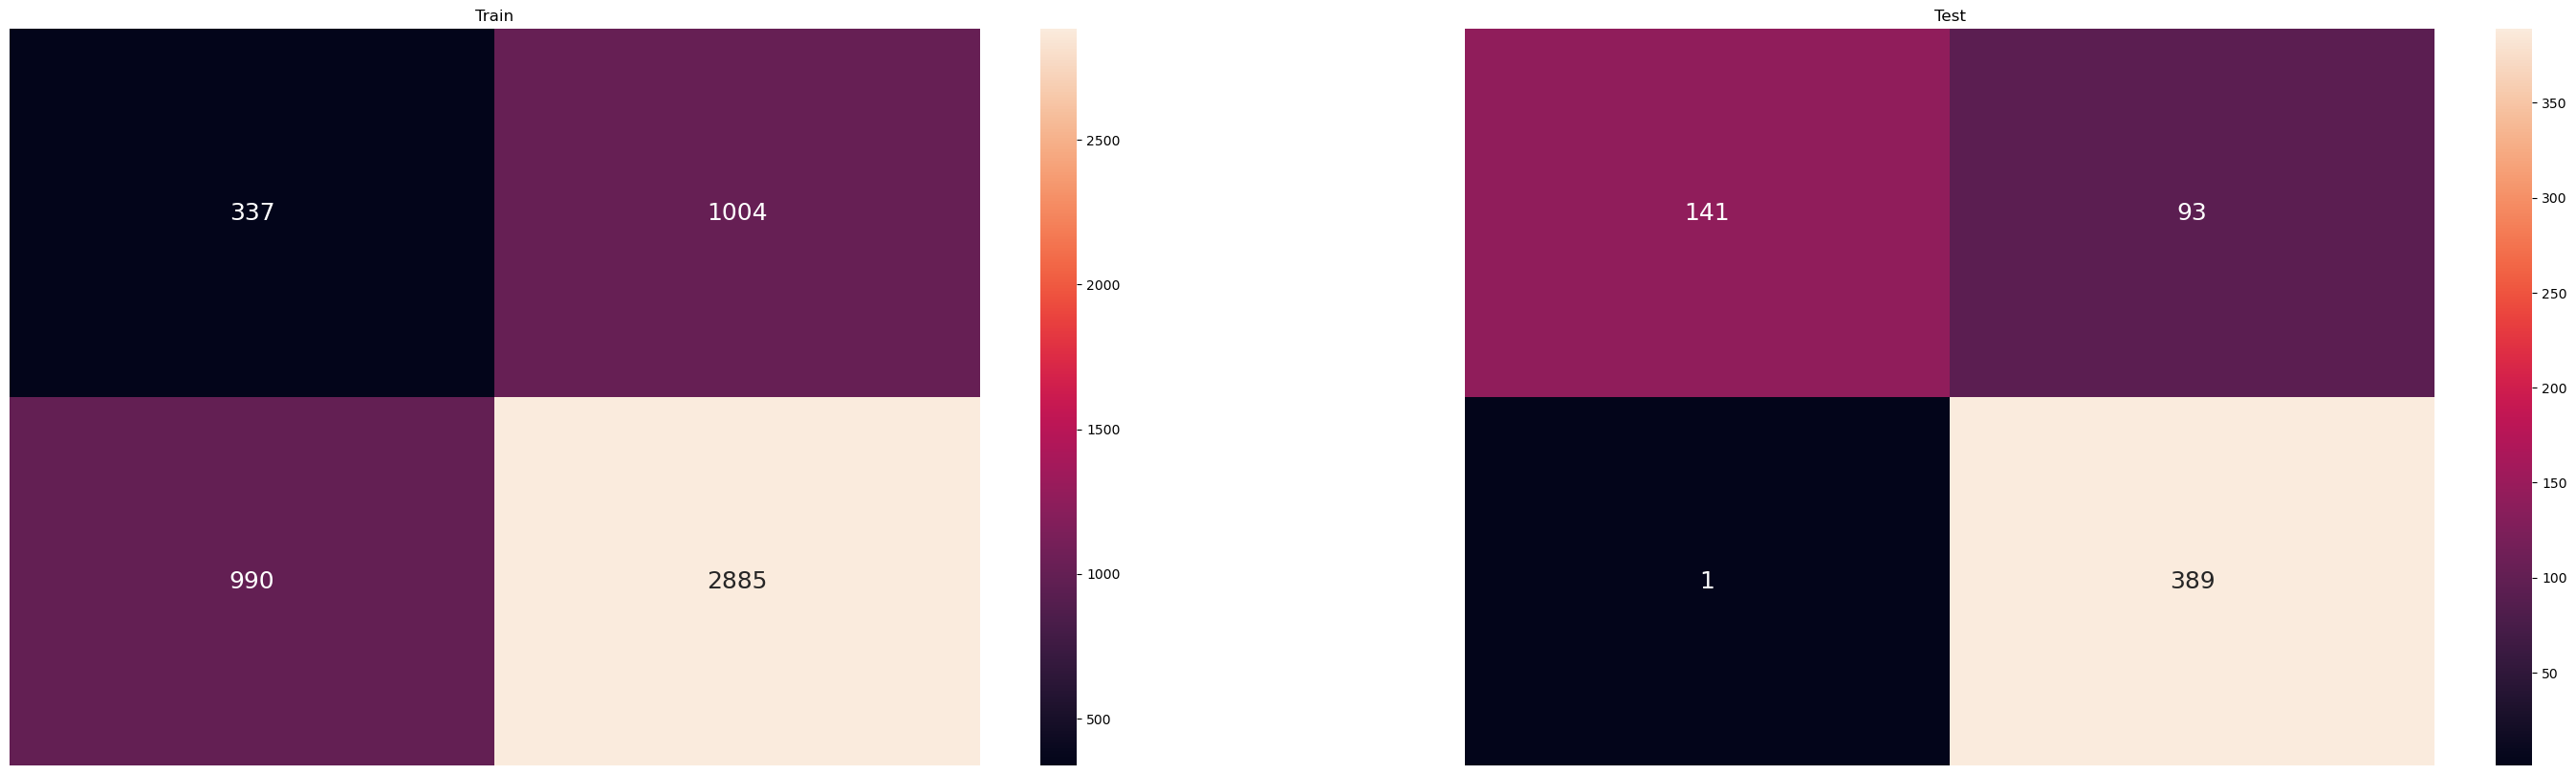

In [144]:
# Confusion matrix

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)
plt.title("Train")
sb.heatmap(_augment_confusion_matrix(model_load, augmented_train_ds)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

ax = plt.subplot(1, 2, 2)
plt.title("Test")
sb.heatmap(_confusion_matrix(model_load, test_set)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

2023-03-24 00:10:25.175718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 7s 7s/step


(-0.5, 255.5, 255.5, -0.5)

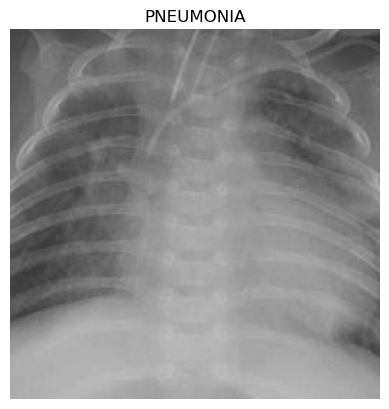

In [145]:
image = tf.keras.utils.load_img("./crop_images/test/PNEUMONIA/person1_virus_8.jpeg.jpeg", target_size=(256, 256))

# load the model
model_load = tf.keras.models.load_model('./augment_model/denseNet121/denseNetModel.h5')
model_load.load_weights('./augment_model/denseNet121/denseNetWeights.h5')

preds = model_load.predict(np.expand_dims(image, axis=0))

i = preds.argmax(axis=1)[0]


plt.imshow(image)
plt.title(training_set.class_names[i])
plt.axis("off")